In [72]:
import pandas as pd
from scipy.stats import kruskal
import pingouin as pg
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from pingouin import partial_corr
import numpy as np
from scipy import stats
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
import warnings
from sklearn import metrics
from sklearn.metrics import roc_curve
from lifelines import CoxPHFitter

In [7]:
# Import basline data that generated by R
df = pd.read_csv("drive/MyDrive/df_bl.csv")

In [11]:
### Calculate demographics of includeded participants at baseline
# Select the desired columns from the DataFrame
columns = ['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'PHS', 'ABETA.bl', 'TAU.bl', 'PTAU.bl',
           'GAP.43', 'PLASMA_NFL', 'MMSE.bl', 'CDRSB.bl', 'ADAS11.bl', 'ADAS13.bl',
           'ADASQ4.bl', 'MOCA.bl', 'DX']
df_selected = df[columns]

# Kruskal-Wallis test for continuous variables
continuous_vars = ['AGE', 'PHS', 'ABETA.bl', 'TAU.bl', 'PTAU.bl',
                   'GAP.43', 'PLASMA_NFL', 'MMSE.bl', 'CDRSB.bl',
                   'ADAS11.bl', 'ADAS13.bl', 'ADASQ4.bl', 'MOCA.bl']

# Perform Kruskal-Wallis test
kw_results = {}
for var in continuous_vars:
    groups = []
    for group, data in df_selected.groupby('DX'):
        groups.append(data[var].values)
    _, p_value = kruskal(*groups)
    kw_results[var] = p_value

print("Kruskal-Wallis test results:")
for var, p_value in kw_results.items():
    print(f"{var}: p-value = {p_value}")

# Perform pairwise comparisons with Bonferroni correction
pairwise_results = []
for var in continuous_vars:
    pairwise = pg.pairwise_gameshowell(data=df_selected, dv=var, between='DX')
    pairwise_results.append(pairwise)

print("Pairwise comparisons (Bonferroni corrected p-values):")
for var, result in zip(continuous_vars, pairwise_results):
    print(f"{var}:")
    print(result)

# Pearson's Chi-squared test for categorical variables
categorical_vars = ['PTGENDER', 'APOE4']
chi2_results = pd.crosstab(df_selected['DX'], df_selected[categorical_vars[0]])
for var in categorical_vars[1:]:
    chi2_results = chi2_results.join(pd.crosstab(df_selected['DX'], df_selected[var]))
print("Pearson's Chi-squared test results:")
print(chi2_results)

# Calculate median and IQR for continuous variables by DX group
medians = df_selected.groupby('DX')[continuous_vars].median()
iqrs = df_selected.groupby('DX')[continuous_vars].quantile(0.75) - df_selected.groupby('DX')[continuous_vars].quantile(0.25)
result = pd.concat([medians, iqrs], axis=1)
result.columns = pd.MultiIndex.from_product([continuous_vars, ['Median', 'IQR']])
print("Median (IQR) by DX group:")
print(result)

# Pearson's Chi-squared test for categorical variables
categorical_vars = ['PTGENDER', 'APOE4']
chi2_results = pd.crosstab(df_selected['DX'], df_selected[categorical_vars[0]])
for var in categorical_vars[1:]:
    chi2_results = chi2_results.join(pd.crosstab(df_selected['DX'], df_selected[var]))
print("Pearson's Chi-squared test results:")
print(chi2_results)


Kruskal-Wallis test results:
AGE: p-value = 0.0022622668045620548
PHS: p-value = 2.48556571029168e-12
ABETA.bl: p-value = 1.1806819378599582e-23
TAU.bl: p-value = 2.047559606418187e-15
PTAU.bl: p-value = 1.3860150528134413e-17
GAP.43: p-value = 2.5556337786309537e-05
PLASMA_NFL: p-value = 3.200966283601461e-07
MMSE.bl: p-value = 2.900528651199797e-56
CDRSB.bl: p-value = 7.313132963378178e-110
ADAS11.bl: p-value = 1.3970889162099381e-61
ADAS13.bl: p-value = 2.4637761551194276e-64
ADASQ4.bl: p-value = 1.4358101868380056e-54
MOCA.bl: p-value = 5.267748659831645e-51
Pairwise comparisons (Bonferroni corrected p-values):
AGE:
    A    B    mean(A)    mean(B)      diff        se         T          df  \
0  AD   CN  73.761290  73.158621  0.602670  0.922567  0.653253  141.187247   
1  AD  MCI  73.761290  71.405143  2.356147  0.915293  2.574199  138.847037   
2  CN  MCI  73.158621  71.405143  1.753478  0.578833  3.029332  500.334895   

       pval    hedges  
0  0.790832  0.090626  
1  0.029673

In [14]:
### Calculate demographics of includeded participants at the subgroup
df = pd.read_csv("drive/MyDrive/long_sub.csv")

# Ignore warnings due to lot of missing data for plasma and CSF biomarkers
warnings.filterwarnings('ignore')

# Select the desired columns from the DataFrame
columns = ['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'PHS', 'ABETA', 'TAU', 'PTAU',
           'GAP.43', 'PLASMA_NFL', 'MMSE', 'CDRSB', 'ADAS11', 'ADAS13',
           'ADASQ4', 'MOCA', 'VISCODE']
df_selected = df[columns]

# Kruskal-Wallis test for continuous variables
continuous_vars = ['AGE', 'PHS', 'ABETA', 'TAU', 'PTAU',
                   'GAP.43', 'PLASMA_NFL', 'MMSE', 'CDRSB',
                   'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']

# Perform Kruskal-Wallis test
kw_results = {}
for var in continuous_vars:
    groups = []
    for group, data in df_selected.groupby('VISCODE'):
        groups.append(data[var].values)
    _, p_value = kruskal(*groups)
    kw_results[var] = p_value

print("Kruskal-Wallis test results:")
for var, p_value in kw_results.items():
    print(f"{var}: p-value = {p_value}")

# Perform pairwise comparisons with Bonferroni correction
pairwise_results = []
for var in continuous_vars:
    pairwise = pg.pairwise_gameshowell(data=df_selected, dv=var, between='VISCODE')
    pairwise_results.append(pairwise)

print("Pairwise comparisons (Bonferroni corrected p-values):")
for var, result in zip(continuous_vars, pairwise_results):
    print(f"{var}:")
    print(result)

# Pearson's Chi-squared test for categorical variables
categorical_vars = ['PTGENDER', 'APOE4']
chi2_results = pd.crosstab(df_selected['VISCODE'], df_selected[categorical_vars[0]])
for var in categorical_vars[1:]:
    chi2_results = chi2_results.join(pd.crosstab(df_selected['VISCODE'], df_selected[var]))
print("Pearson's Chi-squared test results:")
print(chi2_results)

# Calculate median and IQR for continuous variables by VISCODE group
medians = df_selected.groupby('VISCODE')[continuous_vars].median()
iqrs = df_selected.groupby('VISCODE')[continuous_vars].quantile(0.75) - df_selected.groupby('VISCODE')[continuous_vars].quantile(0.25)
result = pd.concat([medians, iqrs], axis=1)
result.columns = pd.MultiIndex.from_product([continuous_vars, ['Median', 'IQR']])
print("Median (IQR) by VISCODE group:")
print(result)

# Pearson's Chi-squared test for categorical variables
categorical_vars = ['PTGENDER', 'APOE4']
chi2_results = pd.crosstab(df_selected['VISCODE'], df_selected[categorical_vars[0]])
for var in categorical_vars[1:]:
    chi2_results = chi2_results.join(pd.crosstab(df_selected['VISCODE'], df_selected[var]))
print("Pearson's Chi-squared test results:")
print(chi2_results)

Kruskal-Wallis test results:
AGE: p-value = 1.0
PHS: p-value = 1.0
ABETA: p-value = nan
TAU: p-value = nan
PTAU: p-value = nan
GAP.43: p-value = nan
PLASMA_NFL: p-value = nan
MMSE: p-value = nan
CDRSB: p-value = nan
ADAS11: p-value = nan
ADAS13: p-value = nan
ADASQ4: p-value = nan
MOCA: p-value = nan
Pairwise comparisons (Bonferroni corrected p-values):
AGE:
    A   B    mean(A)    mean(B)  diff        se    T     df  pval  hedges
0   0  12  70.204211  70.204211   0.0  0.737213  0.0  378.0   1.0     0.0
1   0  24  70.204211  70.204211   0.0  0.737213  0.0  378.0   1.0     0.0
2   0  36  70.204211  70.204211   0.0  0.737213  0.0  378.0   1.0     0.0
3   0  48  70.204211  70.204211   0.0  0.737213  0.0  378.0   1.0     0.0
4  12  24  70.204211  70.204211   0.0  0.737213  0.0  378.0   1.0     0.0
5  12  36  70.204211  70.204211   0.0  0.737213  0.0  378.0   1.0     0.0
6  12  48  70.204211  70.204211   0.0  0.737213  0.0  378.0   1.0     0.0
7  24  36  70.204211  70.204211   0.0  0.737213

In [15]:
### Import basline data to analyze ROC curve
df = pd.read_csv("drive/MyDrive/df_bl.csv")

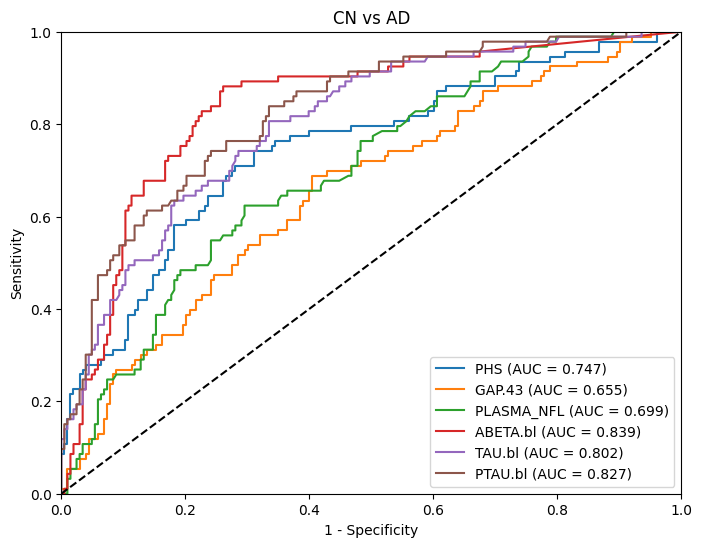

,Variable,AUC,CI Low,CI High,p-value
0,PHS,0.747179,0.686741,0.807037,8.730197e-12
1,GAP.43,0.655172,0.585892,0.721874,1.828085e-05
2,PLASMA_NFL,0.699110,0.639323,0.757494,3.830628e-08
3,ABETA.bl,0.839080,0.784439,0.890318,4.230428e-21
4,TAU.bl,0.801870,0.749266,0.852249,7.651739e-17
5,PTAU.bl,0.827030,0.779033,0.874097,1.695012e-19


In [18]:
## CN vs AD ROC test with Baseline data
df_filtered = df[df['DX'].isin(['CN', 'AD'])]

results = []

variables = ['PHS', 'GAP.43', 'PLASMA_NFL', 'ABETA.bl', 'TAU.bl', 'PTAU.bl']

for variable in variables:
    cn_values = df_filtered[df_filtered['DX'] == 'CN'][variable]
    ad_values = df_filtered[df_filtered['DX'] == 'AD'][variable]

    if variable == 'ABETA.bl':
        fpr, tpr, thresholds = metrics.roc_curve(df_filtered['DX'], -df_filtered[variable], pos_label='AD')
    else:
        fpr, tpr, thresholds = metrics.roc_curve(df_filtered['DX'], df_filtered[variable], pos_label='AD')
    
    auc = metrics.auc(fpr, tpr)

    # Perform bootstrapping
    np.random.seed(0)
    n_iterations = 1000
    auc_bootstrapped = []
    for _ in range(n_iterations):
        cn_samples = np.random.choice(cn_values, size=len(cn_values), replace=True)
        ad_samples = np.random.choice(ad_values, size=len(ad_values), replace=True)
        if variable == 'ABETA.bl':
            fpr, tpr, _ = metrics.roc_curve(
                np.concatenate((['CN'] * len(cn_samples), ['AD'] * len(ad_samples))),
                -np.concatenate((cn_samples, ad_samples)),
                pos_label='AD'
            )
        else:
            fpr, tpr, _ = metrics.roc_curve(
                np.concatenate((['CN'] * len(cn_samples), ['AD'] * len(ad_samples))),
                np.concatenate((cn_samples, ad_samples)),
                pos_label='AD'
            )
        auc_bootstrapped.append(metrics.auc(fpr, tpr))
    
    auc_bootstrapped = np.array(auc_bootstrapped)
    ci_low, ci_high = np.percentile(auc_bootstrapped, [2.5, 97.5])
    
    _, p_value = stats.mannwhitneyu(cn_values, ad_values, alternative='two-sided')
    
    results.append([variable, auc, ci_low, ci_high, p_value])

results_df = pd.DataFrame(results, columns=['Variable', 'AUC', 'CI Low', 'CI High', 'p-value'])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for variable in variables:
    if variable == 'ABETA.bl':
        fpr, tpr, thresholds = metrics.roc_curve(df_filtered['DX'], -df_filtered[variable], pos_label='AD')
    else:
        fpr, tpr, thresholds = metrics.roc_curve(df_filtered['DX'], df_filtered[variable], pos_label='AD')
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{variable} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('CN vs AD')
plt.legend(loc='lower right')
plt.grid(False)
plt.savefig('ROC_CN_AD.pdf', format='pdf')
plt.show()

# Save the table 
results_df.to_csv('/content/ROC_CN_AD.tsv', sep='\t', index=False)
results_df.head(10)

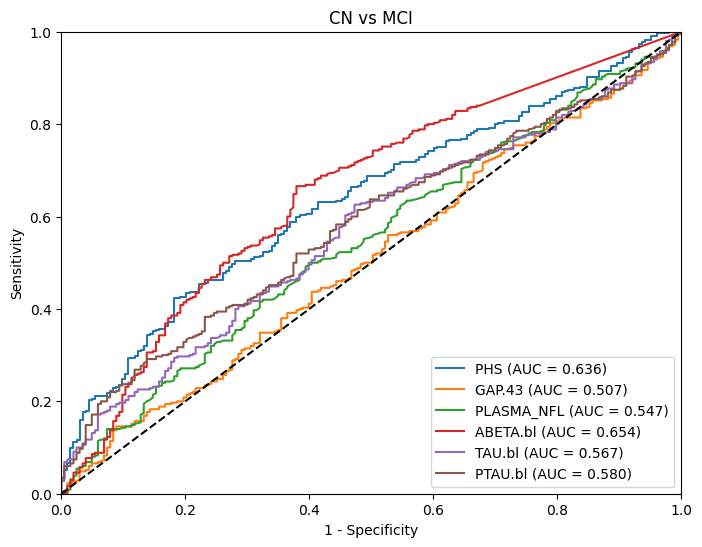

,Variable,AUC,CI Low,CI High,p-value
0,PHS,0.636439,0.583333,0.680329,8.687956e-08
1,GAP.43,0.507354,0.457330,0.555208,7.731783e-01
2,PLASMA_NFL,0.547002,0.497019,0.596512,6.523714e-02
3,ABETA.bl,0.654187,0.607717,0.700188,1.192740e-09
4,TAU.bl,0.567481,0.516996,0.613223,8.121216e-03
5,PTAU.bl,0.580352,0.531004,0.626519,1.621973e-03


In [21]:
## CN vs MCI ROC test with Baseline data
df_filtered = df[df['DX'].isin(['CN', 'MCI'])]

results = []

variables = ['PHS', 'GAP.43', 'PLASMA_NFL', 'ABETA.bl', 'TAU.bl', 'PTAU.bl']

for variable in variables:
    cn_values = df_filtered[df_filtered['DX'] == 'CN'][variable]
    ad_values = df_filtered[df_filtered['DX'] == 'MCI'][variable]

    if variable == 'ABETA.bl':
        fpr, tpr, thresholds = metrics.roc_curve(df_filtered['DX'], -df_filtered[variable], pos_label='MCI')
    else:
        fpr, tpr, thresholds = metrics.roc_curve(df_filtered['DX'], df_filtered[variable], pos_label='MCI')
    
    auc = metrics.auc(fpr, tpr)

    # Perform bootstrapping
    np.random.seed(0)
    n_iterations = 1000
    auc_bootstrapped = []
    for _ in range(n_iterations):
        cn_samples = np.random.choice(cn_values, size=len(cn_values), replace=True)
        ad_samples = np.random.choice(ad_values, size=len(ad_values), replace=True)
        if variable == 'ABETA.bl':
            fpr, tpr, _ = metrics.roc_curve(
                np.concatenate((['CN'] * len(cn_samples), ['MCI'] * len(ad_samples))),
                -np.concatenate((cn_samples, ad_samples)),
                pos_label='MCI'
            )
        else:
            fpr, tpr, _ = metrics.roc_curve(
                np.concatenate((['CN'] * len(cn_samples), ['MCI'] * len(ad_samples))),
                np.concatenate((cn_samples, ad_samples)),
                pos_label='MCI'
            )
        auc_bootstrapped.append(metrics.auc(fpr, tpr))
    
    auc_bootstrapped = np.array(auc_bootstrapped)
    ci_low, ci_high = np.percentile(auc_bootstrapped, [2.5, 97.5])
    
    _, p_value = stats.mannwhitneyu(cn_values, ad_values, alternative='two-sided')
    
    results.append([variable, auc, ci_low, ci_high, p_value])

results_df = pd.DataFrame(results, columns=['Variable', 'AUC', 'CI Low', 'CI High', 'p-value'])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for variable in variables:
    if variable == 'ABETA.bl':
        fpr, tpr, thresholds = metrics.roc_curve(df_filtered['DX'], -df_filtered[variable], pos_label='MCI')
    else:
        fpr, tpr, thresholds = metrics.roc_curve(df_filtered['DX'], df_filtered[variable], pos_label='MCI')
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{variable} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('CN vs MCI')
plt.legend(loc='lower right')
plt.grid(False)
plt.savefig('ROC_CN_MCI.pdf', format='pdf')
plt.show()

# Save the table 
results_df.to_csv('/content/ROC_CN_MCI.tsv', sep='\t', index=False)
results_df.head(10)

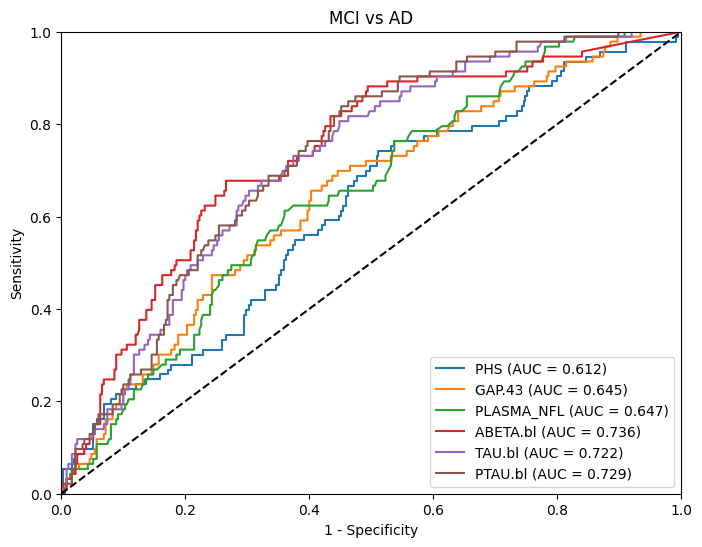

,Variable,AUC,CI Low,CI High,p-value
0,PHS,0.611582,0.549256,0.673487,9.359691e-04
1,GAP.43,0.644747,0.579193,0.704641,1.764642e-05
2,PLASMA_NFL,0.647419,0.591180,0.705393,1.230707e-05
3,ABETA.bl,0.736329,0.673444,0.789783,2.253350e-12
4,TAU.bl,0.722043,0.667275,0.772750,4.536685e-11
5,PTAU.bl,0.729278,0.676835,0.777674,1.046261e-11


In [22]:
## MCI vs AD ROC test with Baseline data
df_filtered = df[df['DX'].isin(['MCI', 'AD'])]

results = []

variables = ['PHS', 'GAP.43', 'PLASMA_NFL', 'ABETA.bl', 'TAU.bl', 'PTAU.bl']

for variable in variables:
    cn_values = df_filtered[df_filtered['DX'] == 'MCI'][variable]
    ad_values = df_filtered[df_filtered['DX'] == 'AD'][variable]

    if variable == 'ABETA.bl':
        fpr, tpr, thresholds = metrics.roc_curve(df_filtered['DX'], -df_filtered[variable], pos_label='AD')
    else:
        fpr, tpr, thresholds = metrics.roc_curve(df_filtered['DX'], df_filtered[variable], pos_label='AD')
    
    auc = metrics.auc(fpr, tpr)

    # Perform bootstrapping
    np.random.seed(0)
    n_iterations = 1000
    auc_bootstrapped = []
    for _ in range(n_iterations):
        cn_samples = np.random.choice(cn_values, size=len(cn_values), replace=True)
        ad_samples = np.random.choice(ad_values, size=len(ad_values), replace=True)
        if variable == 'ABETA.bl':
            fpr, tpr, _ = metrics.roc_curve(
                np.concatenate((['MCI'] * len(cn_samples), ['AD'] * len(ad_samples))),
                -np.concatenate((cn_samples, ad_samples)),
                pos_label='AD'
            )
        else:
            fpr, tpr, _ = metrics.roc_curve(
                np.concatenate((['MCI'] * len(cn_samples), ['AD'] * len(ad_samples))),
                np.concatenate((cn_samples, ad_samples)),
                pos_label='AD'
            )
        auc_bootstrapped.append(metrics.auc(fpr, tpr))
    
    auc_bootstrapped = np.array(auc_bootstrapped)
    ci_low, ci_high = np.percentile(auc_bootstrapped, [2.5, 97.5])
    
    _, p_value = stats.mannwhitneyu(cn_values, ad_values, alternative='two-sided')
    
    results.append([variable, auc, ci_low, ci_high, p_value])

results_df = pd.DataFrame(results, columns=['Variable', 'AUC', 'CI Low', 'CI High', 'p-value'])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for variable in variables:
    if variable == 'ABETA.bl':
        fpr, tpr, thresholds = metrics.roc_curve(df_filtered['DX'], -df_filtered[variable], pos_label='AD')
    else:
        fpr, tpr, thresholds = metrics.roc_curve(df_filtered['DX'], df_filtered[variable], pos_label='AD')
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{variable} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('MCI vs AD')
plt.legend(loc='lower right')
plt.grid(False)
plt.savefig('ROC_MCI_AD.pdf', format='pdf')
plt.show()

# Save the table 
results_df.to_csv('/content/ROC_MCI_AD.tsv', sep='\t', index=False)
results_df.head(10)

['AD&MCI' 'CN']


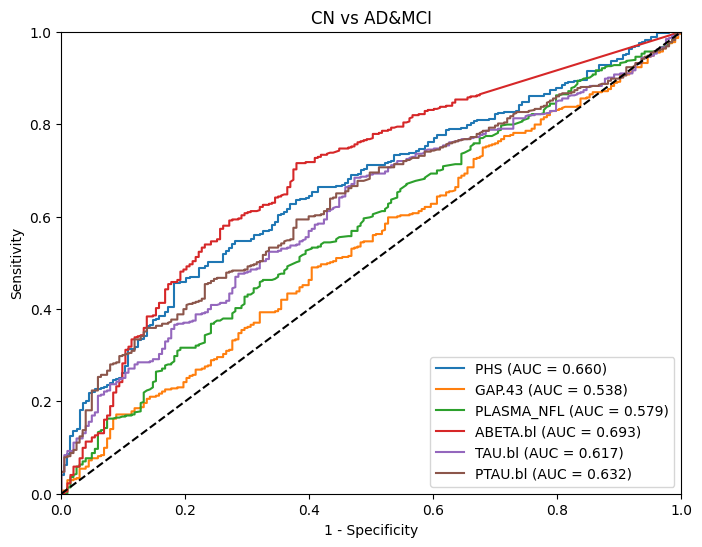

,Variable,AUC,CI Low,CI High,p-value
0,PHS,0.611582,0.549256,0.673487,9.359691e-04
1,GAP.43,0.644747,0.579193,0.704641,1.764642e-05
2,PLASMA_NFL,0.647419,0.591180,0.705393,1.230707e-05
3,ABETA.bl,0.736329,0.673444,0.789783,2.253350e-12
4,TAU.bl,0.722043,0.667275,0.772750,4.536685e-11
5,PTAU.bl,0.729278,0.676835,0.777674,1.046261e-11


In [23]:
## CN vs AD&MCI ROC test with Baseline data
df_C_AM = df[['AGE', 'PTEDUCAT', 'MMSE', 'ABETA.bl', 'TAU.bl', 'PTAU.bl', 'PHS', 'GAP.43', 'PLASMA_NFL', 'PTGENDER', 'APOE4', 'DX']].copy()
df_C_AM['DX'] = df_C_AM['DX'].replace(['MCI', 'AD'], 'AD&MCI')
unique_values = df_C_AM['DX'].unique()
print(unique_values)

df_C_AM_filtered = df_C_AM[df_C_AM['DX'].isin(['CN', 'AD&MCI'])]

results = []

variables = ['PHS', 'GAP.43', 'PLASMA_NFL', 'ABETA.bl', 'TAU.bl', 'PTAU.bl']

for variable in variables:
    cn_values = df_C_AM_filtered[df_C_AM_filtered['DX'] == 'CN'][variable]
    ad_values = df_C_AM_filtered[df_C_AM_filtered['DX'] == 'AD&MCI'][variable]

    if variable == 'ABETA.bl':
        fpr, tpr, thresholds = metrics.roc_curve(df_C_AM_filtered['DX'], -df_C_AM_filtered[variable], pos_label='AD&MCI')
    else:
        fpr, tpr, thresholds = metrics.roc_curve(df_C_AM_filtered['DX'], df_C_AM_filtered[variable], pos_label='AD&MCI')
    
    auc = metrics.auc(fpr, tpr)

    # Perform bootstrapping
    np.random.seed(0)
    n_iterations = 1000
    auc_bootstrapped = []
    for _ in range(n_iterations):
        cn_samples = np.random.choice(cn_values, size=len(cn_values), replace=True)
        ad_samples = np.random.choice(ad_values, size=len(ad_values), replace=True)
        if variable == 'ABETA.bl':
            fpr, tpr, _ = metrics.roc_curve(
                np.concatenate((['CN'] * len(cn_samples), ['AD&MCI'] * len(ad_samples))),
                -np.concatenate((cn_samples, ad_samples)),
                pos_label='AD&MCI'
            )
        else:
            fpr, tpr, _ = metrics.roc_curve(
                np.concatenate((['CN'] * len(cn_samples), ['AD&MCI'] * len(ad_samples))),
                np.concatenate((cn_samples, ad_samples)),
                pos_label='AD&MCI'
            )
        auc_bootstrapped.append(metrics.auc(fpr, tpr))
    
    auc_bootstrapped = np.array(auc_bootstrapped)
    ci_low, ci_high = np.percentile(auc_bootstrapped, [2.5, 97.5])
    
    _, p_value = stats.mannwhitneyu(cn_values, ad_values, alternative='two-sided')
    
    results.append([variable, auc, ci_low, ci_high, p_value])

results_df_C_AM = pd.DataFrame(results, columns=['Variable', 'AUC', 'CI Low', 'CI High', 'p-value'])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for variable in variables:
    if variable == 'ABETA.bl':
        fpr, tpr, thresholds = metrics.roc_curve(df_C_AM_filtered['DX'], -df_C_AM_filtered[variable], pos_label='AD&MCI')
    else:
        fpr, tpr, thresholds = metrics.roc_curve(df_C_AM_filtered['DX'], df_C_AM_filtered[variable], pos_label='AD&MCI')
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{variable} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('CN vs AD&MCI')
plt.legend(loc='lower right')
plt.grid(False)
plt.savefig('ROC_CN_AD&MCI.pdf', format='pdf')
plt.show()

# Save the table 
results_df_C_AM.to_csv('/content/ROC_CN_AD&MCI.tsv', sep='\t', index=False)
results_df.head(10)

['CN&MCI' 'AD']


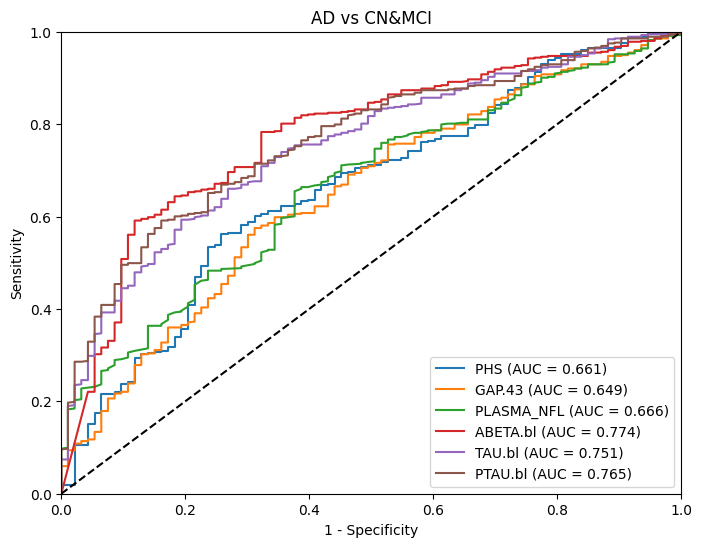

,Variable,AUC,CI Low,CI High,p-value
0,PHS,0.611582,0.549256,0.673487,9.359691e-04
1,GAP.43,0.644747,0.579193,0.704641,1.764642e-05
2,PLASMA_NFL,0.647419,0.591180,0.705393,1.230707e-05
3,ABETA.bl,0.736329,0.673444,0.789783,2.253350e-12
4,TAU.bl,0.722043,0.667275,0.772750,4.536685e-11
5,PTAU.bl,0.729278,0.676835,0.777674,1.046261e-11


In [24]:
## AD vs CN&MCI ROC test with Baseline data
df_A_CM = df[['AGE', 'PTEDUCAT', 'MMSE', 'ABETA.bl', 'TAU.bl', 'PTAU.bl', 'PHS', 'GAP.43', 'PLASMA_NFL', 'PTGENDER', 'APOE4', 'DX']].copy()
df_A_CM['DX'] = df_A_CM['DX'].replace(['MCI', 'CN'], 'CN&MCI')
unique_values = df_A_CM['DX'].unique()
print(unique_values)

df_A_CM_filtered = df_A_CM[df_A_CM['DX'].isin(['AD', 'CN&MCI'])]

results = []

variables = ['PHS', 'GAP.43', 'PLASMA_NFL', 'ABETA.bl', 'TAU.bl', 'PTAU.bl']

for variable in variables:
    cn_values = df_A_CM_filtered[df_A_CM_filtered['DX'] == 'AD'][variable]
    ad_values = df_A_CM_filtered[df_A_CM_filtered['DX'] == 'CN&MCI'][variable]

    if variable == 'ABETA.bl':
        fpr, tpr, thresholds = metrics.roc_curve(df_A_CM_filtered['DX'], df_A_CM_filtered[variable], pos_label='CN&MCI')
    else:
        fpr, tpr, thresholds = metrics.roc_curve(df_A_CM_filtered['DX'], -df_A_CM_filtered[variable], pos_label='CN&MCI')
    
    auc = metrics.auc(fpr, tpr)

    # Perform bootstrapping
    np.random.seed(0)
    n_iterations = 1000
    auc_bootstrapped = []
    for _ in range(n_iterations):
        cn_samples = np.random.choice(cn_values, size=len(cn_values), replace=True)
        ad_samples = np.random.choice(ad_values, size=len(ad_values), replace=True)
        if variable == 'ABETA.bl':
            fpr, tpr, _ = metrics.roc_curve(
                np.concatenate((['AD'] * len(cn_samples), ['CN&MCI'] * len(ad_samples))),
                np.concatenate((cn_samples, ad_samples)),
                pos_label='CN&MCI'
            )
        else:
            fpr, tpr, _ = metrics.roc_curve(
                np.concatenate((['AD'] * len(cn_samples), ['CN&MCI'] * len(ad_samples))),
                -np.concatenate((cn_samples, ad_samples)),
                pos_label='CN&MCI'
            )
        auc_bootstrapped.append(metrics.auc(fpr, tpr))
    
    auc_bootstrapped = np.array(auc_bootstrapped)
    ci_low, ci_high = np.percentile(auc_bootstrapped, [2.5, 97.5])
    
    _, p_value = stats.mannwhitneyu(cn_values, ad_values, alternative='two-sided')
    
    results.append([variable, auc, ci_low, ci_high, p_value])

results_df_A_CM = pd.DataFrame(results, columns=['Variable', 'AUC', 'CI Low', 'CI High', 'p-value'])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for variable in variables:
    if variable == 'ABETA.bl':
        fpr, tpr, thresholds = metrics.roc_curve(df_A_CM_filtered['DX'], df_A_CM_filtered[variable], pos_label='CN&MCI')
    else:
        fpr, tpr, thresholds = metrics.roc_curve(df_A_CM_filtered['DX'], -df_A_CM_filtered[variable], pos_label='CN&MCI')
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{variable} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('AD vs CN&MCI')
plt.legend(loc='lower right')
plt.grid(False)
plt.savefig('ROC_AD_CN&MCI.pdf', format='pdf')
plt.show()

# Save the table 
results_df_A_CM.to_csv('/content/ROC_AD_CN&MCI.tsv', sep='\t', index=False)
results_df.head(10)

In [27]:
## Find the cutoff for CN vs AD
phs_cn = df[df['DX'] == 'CN']['PHS']
phs_ad = df[df['DX'] == 'AD']['PHS']

# Calculate the True Positive Rate (Sensitivity) and False Positive Rate (1 - Specificity)
fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(phs_cn)), np.ones(len(phs_ad))]), np.concatenate([phs_cn, phs_ad]))

# Calculate the Youden index for each threshold
youden_indices = tpr - fpr

# Find the threshold with the maximum Youden index
best_threshold_index = np.argmax(youden_indices)
best_threshold = thresholds[best_threshold_index]
best_youden_index = youden_indices[best_threshold_index]

print("Best cutoff point for CN vs AD:", best_threshold)
print("Youden index for CN vs AD:", best_youden_index)

## Find the cutoff for CN vs MCI
phs_cn = df[df['DX'] == 'CN']['PHS']
phs_MCI = df[df['DX'] == 'MCI']['PHS']

# Calculate the True Positive Rate (Sensitivity) and False Positive Rate (1 - Specificity)
fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(phs_cn)), np.ones(len(phs_MCI))]), np.concatenate([phs_cn, phs_MCI]))

# Calculate the Youden index for each threshold
youden_indices = tpr - fpr

# Find the threshold with the maximum Youden index
best_threshold_index = np.argmax(youden_indices)
best_threshold = thresholds[best_threshold_index]
best_youden_index = youden_indices[best_threshold_index]

print("Best cutoff point for CN vs MCI:", best_threshold)
print("Youden index for CN vs MCI:", best_youden_index)

## Find the cutoff for MCI vs AD
phs_MCI = df[df['DX'] == 'MCI']['PHS']
phs_ad = df[df['DX'] == 'AD']['PHS']

# Calculate the True Positive Rate (Sensitivity) and False Positive Rate (1 - Specificity)
fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(phs_MCI)), np.ones(len(phs_ad))]), np.concatenate([phs_MCI, phs_ad]))

# Calculate the Youden index for each threshold
youden_indices = tpr - fpr

# Find the threshold with the maximum Youden index
best_threshold_index = np.argmax(youden_indices)
best_threshold = thresholds[best_threshold_index]
best_youden_index = youden_indices[best_threshold_index]

print("Best cutoff point for MCI vs AD:", best_threshold)
print("Youden index for MCI vs AD:", best_youden_index)

## Find the cutoff for CN vs AD&MCI
phs_cn = df_C_AM[df_C_AM['DX'] == 'CN']['PHS']
phs_ad = df_C_AM[df_C_AM['DX'] == 'AD&MCI']['PHS']

# Calculate the True Positive Rate (Sensitivity) and False Positive Rate (1 - Specificity)
fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(phs_cn)), np.ones(len(phs_ad))]), np.concatenate([phs_cn, phs_ad]))

# Calculate the Youden index for each threshold
youden_indices = tpr - fpr

# Find the threshold with the maximum Youden index
best_threshold_index = np.argmax(youden_indices)
best_threshold = thresholds[best_threshold_index]
best_youden_index = youden_indices[best_threshold_index]

print("Best cutoff point for CN vs AD&MCI:", best_threshold)
print("Youden index for CN vs AD&MCI:", best_youden_index)

## Find the cutoff for CN&MCI vs AD
phs_cn = df_A_CM[df_A_CM['DX'] == 'CN&MCI']['PHS']
phs_ad = df_A_CM[df_A_CM['DX'] == 'AD']['PHS']

# Calculate the True Positive Rate (Sensitivity) and False Positive Rate (1 - Specificity)
fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(phs_cn)), np.ones(len(phs_ad))]), np.concatenate([phs_cn, phs_ad]))

# Calculate the Youden index for each threshold
youden_indices = tpr - fpr

# Find the threshold with the maximum Youden index
best_threshold_index = np.argmax(youden_indices)
best_threshold = thresholds[best_threshold_index]
best_youden_index = youden_indices[best_threshold_index]

print("Best cutoff point for CN&MCI vs AD:", best_threshold)
print("Youden index for CN&MCI vs AD:", best_youden_index)

Best cutoff point for CN vs AD: 0.210485
Youden index for CN vs AD: 0.43159065628476084
Best cutoff point for CN vs MCI: 0.654003
Youden index for CN vs MCI: 0.24059113300492613
Best cutoff point for MCI vs AD: 0.210485
Youden index for MCI vs AD: 0.2305069124423963
Best cutoff point for CN vs AD&MCI: 0.654003
Youden index for CN vs AD&MCI: 0.2737159314570383
Best cutoff point for CN&MCI vs AD: 0.210485
Youden index for CN&MCI vs AD: 0.30432246397946683


In [31]:
df_bl = df
df_bl['AGE'] = pd.to_numeric(df_bl['AGE'], errors='coerce')
df_bl['PTEDUCAT'] = pd.to_numeric(df_bl['PTEDUCAT'], errors='coerce')
df_bl['APOE4'] = pd.to_numeric(df_bl['APOE4'], errors='coerce')
df_bl['PTGENDER'] = pd.factorize(df_bl['PTGENDER'])[0]
df_bl['phs_bin'] = '-'
df_bl.loc[df_bl['PHS'] > 0.210485, 'phs_bin'] = '+'
df_bl['DP'] = df_bl['DX'] + df_bl['phs_bin']

In [43]:
### Perform partial spearman rank correlation for GAP-43 inbasline data
### The correlation adjusted for age, gender, edjucation, and APOE4
variables = ['ABETA.bl', 'TAU.bl', 'PTAU.bl', 'PLASMA_NFL', 'MMSE.bl', 'CDRSB.bl',
             'ADAS11.bl', 'ADAS13.bl', 'ADASQ4.bl', 'MOCA.bl']

correction_table = pd.DataFrame()
num_tests = 30

for var in variables:
    cn_corr = partial_corr(df_bl.loc[df_bl['DX'] == 'CN'], x='GAP.43', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    mci_corr = partial_corr(df_bl.loc[df_bl['DX'] == 'MCI'], x='GAP.43', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    ad_corr = partial_corr(df_bl.loc[df_bl['DX'] == 'AD'], x='GAP.43', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    
    cn_rs = cn_corr['r'].values[0] if not cn_corr.empty else None
    cn_p = cn_corr['p-val'].values[0] if not cn_corr.empty else None
    cn_padj = cn_corr['p-val'].values[0] * num_tests if not cn_corr.empty else None

    mci_rs = mci_corr['r'].values[0] if not mci_corr.empty else None
    mci_p = mci_corr['p-val'].values[0] if not mci_corr.empty else None
    mci_padj = mci_corr['p-val'].values[0] * num_tests if not mci_corr.empty else None

    ad_rs = ad_corr['r'].values[0] if not ad_corr.empty else None
    ad_p = ad_corr['p-val'].values[0] if not ad_corr.empty else None
    ad_padj = ad_corr['p-val'].values[0] * num_tests if not ad_corr.empty else None
    
    correction_table = correction_table.append({
        'Variable': var,
        'CN_rs': cn_rs,
        'CN_p': cn_p,
        'CN_padj': min(cn_padj, 1),
        'MCI_rs': mci_rs,
        'MCI_p': mci_p,
        'MCI_padj': min(mci_padj, 1),
        'AD_rs': ad_rs,
        'AD_p': ad_p,
        'AD_padj': min(ad_padj, 1)
    }, ignore_index=True)

correction_table.to_csv('/content/gap43_partial_cor.tsv', sep='\t', index=False)
correction_table.head(20)

,Variable,CN_rs,CN_p,CN_padj,MCI_rs,MCI_p,MCI_padj,AD_rs,AD_p,AD_padj
0,ABETA.bl,0.283097,5.086522e-05,1.525957e-03,0.094712,7.852348e-02,1.000000e+00,0.243092,2.170734e-02,6.512203e-01
1,TAU.bl,0.763068,3.372464e-39,1.011739e-37,0.813782,4.391260e-83,1.317378e-81,0.657801,2.497218e-12,7.491655e-11
2,PTAU.bl,0.767676,6.265181e-40,1.879554e-38,0.793385,3.740397e-76,1.122119e-74,0.630346,3.609906e-11,1.082972e-09
3,PLASMA_NFL,-0.010983,8.776365e-01,1.000000e+00,0.012747,8.132274e-01,1.000000e+00,-0.020195,8.509989e-01,1.000000e+00
4,MMSE.bl,0.020480,7.740216e-01,1.000000e+00,-0.150035,5.164992e-03,1.549497e-01,0.006615,9.509423e-01,1.000000e+00
5,CDRSB.bl,0.017546,8.056957e-01,1.000000e+00,0.061770,2.518297e-01,1.000000e+00,0.017069,8.738578e-01,1.000000e+00
6,ADAS11.bl,-0.065730,3.563241e-01,1.000000e+00,0.098649,6.683210e-02,1.000000e+00,0.005788,9.570692e-01,1.000000e+00
7,ADAS13.bl,-0.062844,3.778766e-01,1.000000e+00,0.140752,8.748468e-03,2.624540e-01,-0.031253,7.712460e-01,1.000000e+00
8,ADASQ4.bl,-0.020841,7.701522e-01,1.000000e+00,0.186755,4.793475e-04,1.438042e-02,-0.075645,4.810845e-01,1.000000e+00
9,MOCA.bl,0.181848,1.015233e-02,3.045698e-01,-0.103236,5.504915e-02,1.000000e+00,0.028597,7.902178e-01,1.000000e+00


In [45]:
### Perform partial spearman rank correlation for GAP-43 in basline data divided by PHS 
### The correlation adjusted for age, gender, edjucation, and APOE4
variables = ['ABETA.bl', 'TAU.bl', 'PTAU.bl', 'PLASMA_NFL', 'MMSE.bl', 'CDRSB.bl',
             'ADAS11.bl', 'ADAS13.bl', 'ADASQ4.bl', 'MOCA.bl']

correction_table = pd.DataFrame()
num_tests = 60

for var in variables:
    cn_minus_corr = partial_corr(df_bl.loc[df_bl['DP'] == 'CN-'], x='GAP.43', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    cn_plus_corr = partial_corr(df_bl.loc[df_bl['DP'] == 'CN+'], x='GAP.43', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    mci_minus_corr = partial_corr(df_bl.loc[df_bl['DP'] == 'MCI-'], x='GAP.43', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')    
    mci_plus_corr = partial_corr(df_bl.loc[df_bl['DP'] == 'MCI+'], x='GAP.43', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    ad_minus_corr = partial_corr(df_bl.loc[df_bl['DP'] == 'AD-'], x='GAP.43', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    ad_plus_corr = partial_corr(df_bl.loc[df_bl['DP'] == 'AD+'], x='GAP.43', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    
    cn_rsn = cn_minus_corr['r'].values[0] if not cn_minus_corr.empty else None
    cn_pn = cn_minus_corr['p-val'].values[0] if not cn_minus_corr.empty else None
    cn_pnj = cn_minus_corr['p-val'].values[0] * num_tests if not cn_minus_corr.empty else None
    
    mci_rsn = mci_minus_corr['r'].values[0] if not mci_minus_corr.empty else None
    mci_pn = mci_minus_corr['p-val'].values[0] if not mci_minus_corr.empty else None
    mci_pnj = mci_minus_corr['p-val'].values[0] * num_tests if not mci_minus_corr.empty else None
    
    ad_rsn = ad_minus_corr['r'].values[0] if not ad_minus_corr.empty else None
    ad_pn = ad_minus_corr['p-val'].values[0] if not ad_minus_corr.empty else None
    ad_pnj = ad_minus_corr['p-val'].values[0] * num_tests if not ad_minus_corr.empty else None

    cn_rsp = cn_plus_corr['r'].values[0] if not cn_plus_corr.empty else None
    cn_pp = cn_plus_corr['p-val'].values[0] if not cn_plus_corr.empty else None
    cn_ppj = cn_plus_corr['p-val'].values[0] * num_tests if not cn_plus_corr.empty else None
    
    mci_rsp = mci_plus_corr['r'].values[0] if not mci_plus_corr.empty else None
    mci_pp = mci_plus_corr['p-val'].values[0] if not mci_plus_corr.empty else None
    mci_ppj = mci_plus_corr['p-val'].values[0] * num_tests if not mci_plus_corr.empty else None
   
    ad_rsp = ad_plus_corr['r'].values[0] if not ad_plus_corr.empty else None
    ad_pp = ad_plus_corr['p-val'].values[0] if not ad_plus_corr.empty else None
    ad_ppj = ad_plus_corr['p-val'].values[0] * num_tests if not ad_plus_corr.empty else None    
    
    correction_table = correction_table.append({
        'Variable': var,
        'CN-_rs': cn_rsn,
        'CN-_p': cn_pn,
        'CN-_padj': min(cn_pnj, 1),
        'CN+_rs': cn_rsp,
        'CN+_p': cn_pp,
        'CN+_padj': min(cn_ppj, 1),
        'MCI-_rs': mci_rsn,
        'MCI-_p': mci_pn,
        'MCI-_padj': min(mci_pnj, 1),
        'MCI+_rs': mci_rsp,
        'MCI+_p': mci_pp,
        'MCI+_padj': min(mci_ppj, 1),
        'AD-_rs': ad_rsn,
        'AD-_p': ad_pn,
        'AD-_padj': min(ad_pnj, 1),
        'AD+_rs': ad_rsp,
        'AD+_p': ad_pp,
        'AD+_padj': min(ad_ppj, 1)
    }, ignore_index=True)

correction_table.to_csv('/content/GAP.43_subgrouped_cor.tsv', sep='\t', index=False)
correction_table.head(20)

,Variable,CN-_rs,CN-_p,CN-_padj,CN+_rs,CN+_p,CN+_padj,MCI-_rs,MCI-_p,MCI-_padj,MCI+_rs,MCI+_p,MCI+_padj,AD-_rs,AD-_p,AD-_padj,AD+_rs,AD+_p,AD+_padj
0,ABETA.bl,0.322666,1.275406e-04,7.652436e-03,0.195498,1.378416e-01,1.000000e+00,0.174122,2.441897e-02,1.000000e+00,0.117569,1.212570e-01,1.000000e+00,0.542446,0.011067,0.664043,0.050214,6.935465e-01,1.000000e+00
1,TAU.bl,0.771181,4.654535e-28,2.792721e-26,0.720517,1.245313e-10,7.471881e-09,0.801370,1.156501e-38,6.939005e-37,0.809779,6.502983e-42,3.901790e-40,0.743581,0.000112,0.006713,0.643627,9.664258e-09,5.798555e-07
2,PTAU.bl,0.778794,6.366609e-29,3.819965e-27,0.709323,3.213239e-10,1.927943e-08,0.779445,2.441881e-35,1.465129e-33,0.795615,1.672517e-39,1.003510e-37,0.677442,0.000741,0.044483,0.632063,2.125065e-08,1.275039e-06
3,PLASMA_NFL,-0.038611,6.553918e-01,1.000000e+00,0.060971,6.464259e-01,1.000000e+00,-0.046587,5.499449e-01,1.000000e+00,0.043574,5.669391e-01,1.000000e+00,0.114588,0.620889,1.000000,-0.131568,3.000551e-01,1.000000e+00
4,MMSE.bl,-0.007568,9.303171e-01,1.000000e+00,0.128077,3.336859e-01,1.000000e+00,-0.048545,5.332858e-01,1.000000e+00,-0.211714,4.914249e-03,2.948549e-01,-0.467792,0.032480,1.000000,0.143889,2.566507e-01,1.000000e+00
5,CDRSB.bl,0.075611,3.816402e-01,1.000000e+00,-0.141286,2.857986e-01,1.000000e+00,-0.004682,9.521124e-01,1.000000e+00,0.130328,8.560386e-02,1.000000e+00,-0.103968,0.653803,1.000000,-0.012876,9.195641e-01,1.000000e+00
6,ADAS11.bl,-0.098947,2.517636e-01,1.000000e+00,0.066808,6.151464e-01,1.000000e+00,-0.032194,6.795905e-01,1.000000e+00,0.211851,4.885860e-03,2.931516e-01,0.267848,0.240445,1.000000,-0.087282,4.928354e-01,1.000000e+00
7,ADAS13.bl,-0.075543,3.820643e-01,1.000000e+00,0.039692,7.653439e-01,1.000000e+00,0.032443,6.772535e-01,1.000000e+00,0.225366,2.712005e-03,1.627203e-01,0.188352,0.413561,1.000000,-0.105739,4.056475e-01,1.000000e+00
8,ADASQ4.bl,0.008098,9.254524e-01,1.000000e+00,-0.019185,8.853266e-01,1.000000e+00,0.165819,3.222460e-02,1.000000e+00,0.167824,2.642125e-02,1.000000e+00,0.115998,0.616572,1.000000,-0.133014,2.947290e-01,1.000000e+00
9,MOCA.bl,0.190022,2.670568e-02,1.000000e+00,0.140780,2.875459e-01,1.000000e+00,-0.008836,9.097646e-01,1.000000e+00,-0.177907,1.850072e-02,1.000000e+00,-0.237084,0.300773,1.000000,0.072385,5.697565e-01,1.000000e+00


In [47]:
### Perform partial spearman rank correlation for NFL inbasline data
### The correlation adjusted for age, gender, edjucation, and APOE4
variables = ['ABETA.bl', 'TAU.bl', 'PTAU.bl', 'GAP.43', 'MMSE.bl', 'CDRSB.bl',
             'ADAS11.bl', 'ADAS13.bl', 'ADASQ4.bl', 'MOCA.bl']

correction_table = pd.DataFrame()
num_tests = 30

for var in variables:
    cn_corr = partial_corr(df_bl.loc[df_bl['DX'] == 'CN'], x='PLASMA_NFL', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    mci_corr = partial_corr(df_bl.loc[df_bl['DX'] == 'MCI'], x='PLASMA_NFL', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    ad_corr = partial_corr(df_bl.loc[df_bl['DX'] == 'AD'], x='PLASMA_NFL', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    
    cn_rs = cn_corr['r'].values[0] if not cn_corr.empty else None
    cn_p = cn_corr['p-val'].values[0] if not cn_corr.empty else None
    cn_padj = cn_corr['p-val'].values[0] * num_tests if not cn_corr.empty else None

    mci_rs = mci_corr['r'].values[0] if not mci_corr.empty else None
    mci_p = mci_corr['p-val'].values[0] if not mci_corr.empty else None
    mci_padj = mci_corr['p-val'].values[0] * num_tests if not mci_corr.empty else None

    ad_rs = ad_corr['r'].values[0] if not ad_corr.empty else None
    ad_p = ad_corr['p-val'].values[0] if not ad_corr.empty else None
    ad_padj = ad_corr['p-val'].values[0] * num_tests if not ad_corr.empty else None
    
    correction_table = correction_table.append({
        'Variable': var,
        'CN_rs': cn_rs,
        'CN_p': cn_p,
        'CN_padj': min(cn_padj, 1),
        'MCI_rs': mci_rs,
        'MCI_p': mci_p,
        'MCI_padj': min(mci_padj, 1),
        'AD_rs': ad_rs,
        'AD_p': ad_p,
        'AD_padj': min(ad_padj, 1)
    }, ignore_index=True)

correction_table.to_csv('/content/nfl_partial_cor.tsv', sep='\t', index=False)
correction_table.head(20)

,Variable,CN_rs,CN_p,CN_padj,MCI_rs,MCI_p,MCI_padj,AD_rs,AD_p,AD_padj
0,ABETA.bl,-0.202344,0.004155,0.124653,-0.088190,0.101487,1.000000,0.061095,0.569525,1
1,TAU.bl,0.071886,0.312974,1.000000,0.061989,0.250145,1.000000,0.063078,0.557035,1
2,PTAU.bl,0.077362,0.277445,1.000000,0.054578,0.311399,1.000000,0.027146,0.800641,1
3,GAP.43,-0.010983,0.877636,1.000000,0.012747,0.813227,1.000000,-0.020195,0.850999,1
4,MMSE.bl,-0.030776,0.666096,1.000000,-0.094904,0.077914,1.000000,-0.035085,0.744114,1
5,CDRSB.bl,0.014756,0.836125,1.000000,0.101068,0.060383,1.000000,0.018534,0.863128,1
6,ADAS11.bl,0.044011,0.537079,1.000000,0.179798,0.000780,0.023404,0.187652,0.078245,1
7,ADAS13.bl,0.084866,0.233343,1.000000,0.213355,0.000063,0.001897,0.149408,0.162280,1
8,ADASQ4.bl,0.023730,0.739370,1.000000,0.208173,0.000096,0.002873,-0.075057,0.484510,1
9,MOCA.bl,-0.081378,0.253187,1.000000,-0.093720,0.081716,1.000000,-0.009084,0.932671,1


In [48]:
### Perform partial spearman rank correlation for NFL inbasline data
### The correlation adjusted for age, gender, edjucation, and APOE4
variables = ['ABETA.bl', 'TAU.bl', 'PTAU.bl', 'GAP.43', 'MMSE.bl', 'CDRSB.bl',
             'ADAS11.bl', 'ADAS13.bl', 'ADASQ4.bl', 'MOCA.bl']

correction_table = pd.DataFrame()
num_tests = 60

for var in variables:
    cn_minus_corr = partial_corr(df_bl.loc[df_bl['DP'] == 'CN-'], x='PLASMA_NFL', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    cn_plus_corr = partial_corr(df_bl.loc[df_bl['DP'] == 'CN+'], x='PLASMA_NFL', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    mci_minus_corr = partial_corr(df_bl.loc[df_bl['DP'] == 'MCI-'], x='PLASMA_NFL', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')    
    mci_plus_corr = partial_corr(df_bl.loc[df_bl['DP'] == 'MCI+'], x='PLASMA_NFL', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    ad_minus_corr = partial_corr(df_bl.loc[df_bl['DP'] == 'AD-'], x='PLASMA_NFL', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    ad_plus_corr = partial_corr(df_bl.loc[df_bl['DP'] == 'AD+'], x='PLASMA_NFL', y=var, covar=['AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4'], method='spearman')
    
    cn_rsn = cn_minus_corr['r'].values[0] if not cn_minus_corr.empty else None
    cn_pn = cn_minus_corr['p-val'].values[0] if not cn_minus_corr.empty else None
    cn_pnj = cn_minus_corr['p-val'].values[0] * num_tests if not cn_minus_corr.empty else None
    
    mci_rsn = mci_minus_corr['r'].values[0] if not mci_minus_corr.empty else None
    mci_pn = mci_minus_corr['p-val'].values[0] if not mci_minus_corr.empty else None
    mci_pnj = mci_minus_corr['p-val'].values[0] * num_tests if not mci_minus_corr.empty else None
    
    ad_rsn = ad_minus_corr['r'].values[0] if not ad_minus_corr.empty else None
    ad_pn = ad_minus_corr['p-val'].values[0] if not ad_minus_corr.empty else None
    ad_pnj = ad_minus_corr['p-val'].values[0] * num_tests if not ad_minus_corr.empty else None

    cn_rsp = cn_plus_corr['r'].values[0] if not cn_plus_corr.empty else None
    cn_pp = cn_plus_corr['p-val'].values[0] if not cn_plus_corr.empty else None
    cn_ppj = cn_plus_corr['p-val'].values[0] * num_tests if not cn_plus_corr.empty else None
    
    mci_rsp = mci_plus_corr['r'].values[0] if not mci_plus_corr.empty else None
    mci_pp = mci_plus_corr['p-val'].values[0] if not mci_plus_corr.empty else None
    mci_ppj = mci_plus_corr['p-val'].values[0] * num_tests if not mci_plus_corr.empty else None
   
    ad_rsp = ad_plus_corr['r'].values[0] if not ad_plus_corr.empty else None
    ad_pp = ad_plus_corr['p-val'].values[0] if not ad_plus_corr.empty else None
    ad_ppj = ad_plus_corr['p-val'].values[0] * num_tests if not ad_plus_corr.empty else None    
    
    correction_table = correction_table.append({
        'Variable': var,
        'CN-_rs': cn_rsn,
        'CN-_p': cn_pn,
        'CN-_padj': min(cn_pnj, 1),
        'CN+_rs': cn_rsp,
        'CN+_p': cn_pp,
        'CN+_padj': min(cn_ppj, 1),
        'MCI-_rs': mci_rsn,
        'MCI-_p': mci_pn,
        'MCI-_padj': min(mci_pnj, 1),
        'MCI+_rs': mci_rsp,
        'MCI+_p': mci_pp,
        'MCI+_padj': min(mci_ppj, 1),
        'AD-_rs': ad_rsn,
        'AD-_p': ad_pn,
        'AD-_padj': min(ad_pnj, 1),
        'AD+_rs': ad_rsp,
        'AD+_p': ad_pp,
        'AD+_padj': min(ad_ppj, 1)
    }, ignore_index=True)

correction_table.to_csv('/content/PLASMA_NFL_subgrouped_cor.tsv', sep='\t', index=False)
correction_table.head(20)

,Variable,CN-_rs,CN-_p,CN-_padj,CN+_rs,CN+_p,CN+_padj,MCI-_rs,MCI-_p,MCI-_padj,MCI+_rs,MCI+_p,MCI+_padj,AD-_rs,AD-_p,AD-_padj,AD+_rs,AD+_p,AD+_padj
0,ABETA.bl,-0.240558,0.004787,0.287224,-0.019023,0.886285,1,-0.097945,0.207937,1.000000,-0.039084,0.607583,1.000000,-0.226513,0.323463,1,0.081136,0.523900,1
1,TAU.bl,0.041769,0.629221,1.000000,0.109999,0.406899,1,0.033633,0.666114,1.000000,0.083113,0.274177,1.000000,0.091331,0.693782,1,0.018949,0.881857,1
2,PTAU.bl,0.045809,0.596409,1.000000,0.144138,0.276086,1,0.026659,0.732365,1.000000,0.074146,0.329474,1.000000,0.080518,0.728628,1,-0.037807,0.766774,1
3,GAP.43,-0.038611,0.655392,1.000000,0.060971,0.646426,1,-0.046587,0.549945,1.000000,0.043574,0.566939,1.000000,0.114588,0.620889,1,-0.131568,0.300055,1
4,MMSE.bl,-0.102938,0.233050,1.000000,0.109842,0.407572,1,-0.118575,0.126957,1.000000,-0.062556,0.410840,1.000000,-0.062524,0.787746,1,-0.109600,0.388621,1
5,CDRSB.bl,0.020542,0.812366,1.000000,0.014975,0.910369,1,-0.033394,0.668338,1.000000,0.196480,0.009160,0.549620,-0.133349,0.564447,1,0.138834,0.273916,1
6,ADAS11.bl,0.028344,0.743245,1.000000,0.146482,0.268267,1,0.140736,0.069663,1.000000,0.207484,0.005867,0.352006,0.452509,0.039426,1,0.008369,0.947670,1
7,ADAS13.bl,0.069755,0.419696,1.000000,0.170632,0.196320,1,0.179527,0.020261,1.000000,0.237353,0.001563,0.093786,0.424338,0.055210,1,-0.000526,0.996709,1
8,ADASQ4.bl,0.019446,0.822211,1.000000,0.063996,0.630136,1,0.205113,0.007836,0.470142,0.208962,0.005517,0.331011,-0.014213,0.951243,1,-0.056477,0.657576,1
9,MOCA.bl,-0.104591,0.225589,1.000000,-0.053912,0.685078,1,-0.014244,0.855031,1.000000,-0.141872,0.061092,1.000000,-0.064444,0.781376,1,-0.043188,0.734720,1


In [49]:
df = pd.read_csv("drive/MyDrive/long_sub.csv")
df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')
df['PTEDUCAT'] = pd.to_numeric(df['PTEDUCAT'], errors='coerce')
df['APOE4'] = pd.to_numeric(df['APOE4'], errors='coerce')
df['PTGENDER'] = pd.factorize(df['PTGENDER'])[0]
df['phs_bin'] = '-'
df.loc[df['PHS'] > 0.210485, 'phs_bin'] = '+'
df['DP'] = df['DX'] + df['phs_bin']

In [50]:
### Perform partial spearman rank correlation for GAP-43.bl in subgroup data during time
### The correlation adjusted for age, gender, edjucation, and APOE4
# Select the relevant columns from the DataFrame
df_subset = df[['VISCODE', 'GAP.43.bl', 'MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA', 'AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4']]

# Define the list of VISCODEs
viscodes = [0, 12, 24, 36, 48]

# Create a table to store the results
result_table = pd.DataFrame(columns=['Variable', 'rs_0', 'p_0', 'p_adj_0', 'rs_12', 'p_12', 'p_adj_12', 'rs_24', 'p_24', 'p_adj_24', 'rs_36', 'p_36', 'p_adj_36', 'rs_48', 'p_48', 'p_adj_48'])

# Perform partial Spearman rank correlation for each variable and VISCODE
for var in ['MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']:
    rs_values = []
    p_values = []
    p_adj_values = []
    
    for viscode in viscodes:
        # Subset the DataFrame for the specific VISCODE
        df_viscode = df_subset[df_subset['VISCODE'] == viscode]

        # Perform partial Spearman rank correlation
        corr, p = spearmanr(df_viscode[['GAP.43.bl', var, 'AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4']].dropna(), axis=0)

        rs_values.append(corr[0, 1])
        p_values.append(p[0, 1])

    # Apply Bonferroni correction
    p_adj_values = multipletests(p_values, method='bonferroni')[1]

    result_table = result_table.append({
        'Variable': var,
        'rs_0': rs_values[0],
        'p_0': p_values[0],
        'p_adj_0': p_adj_values[0],
        'rs_12': rs_values[1],
        'p_12': p_values[1],
        'p_adj_12': p_adj_values[1],
        'rs_24': rs_values[2],
        'p_24': p_values[2],
        'p_adj_24': p_adj_values[2],
        'rs_36': rs_values[3],
        'p_36': p_values[3],
        'p_adj_36': p_adj_values[3],
        'rs_48': rs_values[4],
        'p_48': p_values[4],
        'p_adj_48': p_adj_values[4]
    }, ignore_index=True)

# Reset the index
result_table.reset_index(drop=True, inplace=True)
result_table.to_csv('/content/gap43_long_cor.csv', sep=',', index=False)
result_table.head(10)

,Variable,rs_0,p_0,p_adj_0,rs_12,p_12,p_adj_12,rs_24,p_24,p_adj_24,rs_36,p_36,p_adj_36,rs_48,p_48,p_adj_48
0,MMSE,-0.244517,0.000674,0.003370,-0.191766,0.008037,0.040185,-0.215155,3.186438e-03,0.015932,-0.225976,0.001982,0.009911,-0.273487,0.000195,0.000976
1,CDRSB,0.099986,0.169887,0.849437,0.149901,0.040589,0.202943,0.162979,2.543608e-02,0.127180,0.211162,0.003720,0.018598,0.264208,0.000279,0.001395
2,ADAS11,0.144632,0.046487,0.232437,0.280035,0.000091,0.000456,0.364261,3.203602e-07,0.000002,0.339732,0.000002,0.000011,0.261097,0.000385,0.001925
3,ADAS13,0.225840,0.001730,0.008651,0.262839,0.000258,0.001291,0.358027,6.043361e-07,0.000003,0.325323,0.000006,0.000031,0.257827,0.000475,0.002377
4,ADASQ4,0.301073,0.000024,0.000122,0.255146,0.000381,0.001906,0.320263,8.338476e-06,0.000042,0.293911,0.000049,0.000245,0.274969,0.000172,0.000861
5,MOCA,-0.165713,0.022316,0.111579,-0.222825,0.002001,0.010004,-0.250962,5.900049e-04,0.002950,-0.238346,0.001195,0.005974,-0.299385,0.000054,0.000271


In [51]:
### Perform partial spearman rank correlation for NFL.bl in subgroup data during time
### The correlation adjusted for age, gender, edjucation, and APOE4
# Select the relevant columns from the DataFrame
df_subset = df[['VISCODE', 'PLASMA_NFL.bl', 'MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA', 'AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4']]

# Define the list of VISCODEs
viscodes = [0, 12, 24, 36, 48]

# Create a table to store the results
result_table = pd.DataFrame(columns=['Variable', 'rs_0', 'p_0', 'p_adj_0', 'rs_12', 'p_12', 'p_adj_12', 'rs_24', 'p_24', 'p_adj_24', 'rs_36', 'p_36', 'p_adj_36', 'rs_48', 'p_48', 'p_adj_48'])

# Perform partial Spearman rank correlation for each variable and VISCODE
for var in ['MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']:
    rs_values = []
    p_values = []
    p_adj_values = []
    
    for viscode in viscodes:
        # Subset the DataFrame for the specific VISCODE
        df_viscode = df_subset[df_subset['VISCODE'] == viscode]

        # Perform partial Spearman rank correlation
        corr, p = spearmanr(df_viscode[['PLASMA_NFL.bl', var, 'AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4']].dropna(), axis=0)

        rs_values.append(corr[0, 1])
        p_values.append(p[0, 1])

    # Apply Bonferroni correction
    p_adj_values = multipletests(p_values, method='bonferroni')[1]

    result_table = result_table.append({
        'Variable': var,
        'rs_0': rs_values[0],
        'p_0': p_values[0],
        'p_adj_0': p_adj_values[0],
        'rs_12': rs_values[1],
        'p_12': p_values[1],
        'p_adj_12': p_adj_values[1],
        'rs_24': rs_values[2],
        'p_24': p_values[2],
        'p_adj_24': p_adj_values[2],
        'rs_36': rs_values[3],
        'p_36': p_values[3],
        'p_adj_36': p_adj_values[3],
        'rs_48': rs_values[4],
        'p_48': p_values[4],
        'p_adj_48': p_adj_values[4]
    }, ignore_index=True)

# Reset the index
result_table.reset_index(drop=True, inplace=True)
result_table.to_csv('/content/nfl_long_cor.csv', sep=',', index=False)
result_table.head(10)


,Variable,rs_0,p_0,p_adj_0,rs_12,p_12,p_adj_12,rs_24,p_24,p_adj_24,rs_36,p_36,p_adj_36,rs_48,p_48,p_adj_48
0,MMSE,-0.242309,0.000756,0.003782,-0.271411,0.000152,0.000760,-0.214085,0.003345,0.016723,-0.348908,1.131177e-06,5.655886e-06,-0.371363,2.649395e-07,1.324697e-06
1,CDRSB,0.063636,0.383069,1.000000,0.140459,0.055190,0.275949,0.231870,0.001366,0.006829,0.287234,6.723795e-05,3.361897e-04,0.335361,3.066164e-06,1.533082e-05
2,ADAS11,0.165316,0.022644,0.113218,0.225494,0.001759,0.008797,0.312161,0.000014,0.000072,0.376645,1.263220e-07,6.316100e-07,0.339641,2.903180e-06,1.451590e-05
3,ADAS13,0.224014,0.001890,0.009449,0.294653,0.000039,0.000193,0.329330,0.000005,0.000025,0.403211,1.266424e-08,6.332120e-08,0.383046,1.113724e-07,5.568618e-07
4,ADASQ4,0.236361,0.001027,0.005133,0.338506,0.000002,0.000009,0.298680,0.000035,0.000173,0.366367,2.915869e-07,1.457934e-06,0.385276,7.846382e-08,3.923191e-07
5,MOCA,-0.242858,0.000735,0.003675,-0.203594,0.004842,0.024208,-0.275408,0.000154,0.000772,-0.342262,2.254375e-06,1.127187e-05,-0.381972,1.685570e-07,8.427850e-07


In [52]:
### Perform partial spearman rank correlation for GAP-43.bl in subgroup data divided by PHS  during time
### The correlation adjusted for age, gender, edjucation, and APOE4
# Select the relevant columns from the DataFrame
df_subset = df[['VISCODE', 'GAP.43.bl', 'MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA', 'AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4', 'phs_bin']]

# Define the list of VISCODEs and phs_bins
viscodes = [0, 12, 24, 36, 48]
phs_bins = ['-', '+']

# Create a table to store the results
result_table = pd.DataFrame(columns=['Variable'] + [f'rs_{viscode}{phs_bin}' for viscode in viscodes for phs_bin in phs_bins] +
                           [f'p_{viscode}{phs_bin}' for viscode in viscodes for phs_bin in phs_bins] +
                           [f'p_adj_{viscode}{phs_bin}' for viscode in viscodes for phs_bin in phs_bins])

# Perform partial Spearman rank correlation for each variable and VISCODE
for var in ['MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']:
    rs_values = []
    p_values = []

    for viscode in viscodes:
        for phs_bin in phs_bins:
            # Subset the DataFrame for the specific VISCODE and phs_bin
            df_viscode = df_subset[(df_subset['VISCODE'] == viscode) & (df_subset['phs_bin'] == phs_bin)]

            # Perform partial Spearman rank correlation
            corr, p = spearmanr(df_viscode[['GAP.43.bl', var, 'AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4']].dropna(), axis=0)

            rs_values.append(corr[0, 1])
            p_values.append(p[0, 1])

    # Apply Bonferroni correction
    p_adj_values = multipletests(p_values, method='bonferroni')[1]

    result_table = result_table.append({
        'Variable': var,
        **{f'rs_{viscode}{phs_bin}': rs_values[i] for i, (viscode, phs_bin) in enumerate(zip(viscodes * len(phs_bins), phs_bins * len(viscodes)))},
        **{f'p_{viscode}{phs_bin}': p_values[i] for i, (viscode, phs_bin) in enumerate(zip(viscodes * len(phs_bins), phs_bins * len(viscodes)))},
        **{f'p_adj_{viscode}{phs_bin}': p_adj_values[i] for i, (viscode, phs_bin) in enumerate(zip(viscodes * len(phs_bins), phs_bins * len(viscodes)))}
    }, ignore_index=True)

# Reset the index
result_table.reset_index(drop=True, inplace=True)
result_table.to_csv('/content/gap43_long_phsbin_cor.csv', sep=',', index=False)
result_table.head(10)

,Variable,rs_0-,rs_0+,rs_12-,rs_12+,rs_24-,rs_24+,rs_36-,rs_36+,rs_48-,...,p_adj_0-,p_adj_0+,p_adj_12-,p_adj_12+,p_adj_24-,p_adj_24+,p_adj_36-,p_adj_36+,p_adj_48-,p_adj_48+
0,MMSE,-0.118096,-0.221794,0.040226,-0.285646,-0.147225,-0.327423,-0.033662,-0.139772,-0.073105,...,1.00000,0.281714,1.0,0.039663,1.0,0.010616,1.0,1.000000,1.000000,0.001874
1,CDRSB,-0.076000,0.236965,-0.029931,0.175657,-0.085990,0.314285,0.066170,0.254106,-0.039891,...,1.00000,0.181979,1.0,0.804461,1.0,0.015346,1.0,0.115753,1.000000,0.015199
2,ADAS11,-0.110895,0.360916,0.173312,0.283706,0.086438,0.364013,0.044457,0.339446,0.256106,...,1.00000,0.002613,1.0,0.042309,1.0,0.002471,1.0,0.005504,0.160206,0.012044
3,ADAS13,-0.003205,0.367908,0.155314,0.328879,0.081035,0.350816,0.047304,0.316725,0.231413,...,1.00000,0.002262,1.0,0.008351,1.0,0.004267,1.0,0.014032,0.300562,0.023022
4,ADASQ4,0.178556,0.377204,0.112064,0.315055,0.079777,0.330147,0.144351,0.287843,0.160347,...,0.92217,0.001288,1.0,0.014097,1.0,0.009581,1.0,0.036847,1.000000,0.044973
5,MOCA,0.036022,-0.258690,-0.053096,-0.280120,-0.059532,-0.298904,-0.126254,-0.298871,-0.144457,...,1.00000,0.109307,1.0,0.047617,1.0,0.032572,1.0,0.025237,1.000000,0.001924


In [53]:
### Perform partial spearman rank correlation for NFL.bl in subgroup data divided by PHS  during time
### The correlation adjusted for age, gender, edjucation, and APOE4
# Select the relevant columns from the DataFrame
df_subset = df[['VISCODE', 'PLASMA_NFL.bl', 'MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA', 'AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4', 'phs_bin']]

# Define the list of VISCODEs and phs_bins
viscodes = [0, 12, 24, 36, 48]
phs_bins = ['-', '+']

# Create a table to store the results
result_table = pd.DataFrame(columns=['Variable'] + [f'rs_{viscode}{phs_bin}' for viscode in viscodes for phs_bin in phs_bins] +
                           [f'p_{viscode}{phs_bin}' for viscode in viscodes for phs_bin in phs_bins] +
                           [f'p_adj_{viscode}{phs_bin}' for viscode in viscodes for phs_bin in phs_bins])

# Perform partial Spearman rank correlation for each variable and VISCODE
for var in ['MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']:
    rs_values = []
    p_values = []

    for viscode in viscodes:
        for phs_bin in phs_bins:
            # Subset the DataFrame for the specific VISCODE and phs_bin
            df_viscode = df_subset[(df_subset['VISCODE'] == viscode) & (df_subset['phs_bin'] == phs_bin)]

            # Perform partial Spearman rank correlation
            corr, p = spearmanr(df_viscode[['PLASMA_NFL.bl', var, 'AGE', 'PTEDUCAT', 'PTGENDER', 'APOE4']].dropna(), axis=0)

            rs_values.append(corr[0, 1])
            p_values.append(p[0, 1])

    # Apply Bonferroni correction
    p_adj_values = multipletests(p_values, method='bonferroni')[1]

    result_table = result_table.append({
        'Variable': var,
        **{f'rs_{viscode}{phs_bin}': rs_values[i] for i, (viscode, phs_bin) in enumerate(zip(viscodes * len(phs_bins), phs_bins * len(viscodes)))},
        **{f'p_{viscode}{phs_bin}': p_values[i] for i, (viscode, phs_bin) in enumerate(zip(viscodes * len(phs_bins), phs_bins * len(viscodes)))},
        **{f'p_adj_{viscode}{phs_bin}': p_adj_values[i] for i, (viscode, phs_bin) in enumerate(zip(viscodes * len(phs_bins), phs_bins * len(viscodes)))}
    }, ignore_index=True)

# Reset the index
result_table.reset_index(drop=True, inplace=True)
result_table.to_csv('/content/nfl_long_phsbin_cor.csv', sep=',', index=False)
result_table.head(10)

,Variable,rs_0-,rs_0+,rs_12-,rs_12+,rs_24-,rs_24+,rs_36-,rs_36+,rs_48-,...,p_adj_0-,p_adj_0+,p_adj_12-,p_adj_12+,p_adj_24-,p_adj_24+,p_adj_36-,p_adj_36+,p_adj_48-,p_adj_48+
0,MMSE,-0.166138,-0.355690,-0.153960,-0.272794,-0.145496,-0.456447,-0.263341,-0.335962,0.005415,...,1.000000,0.003253,1.000000,0.060340,1.000000,0.000026,0.142936,0.006325,1.000000,8.967415e-05
1,CDRSB,-0.151132,0.345456,0.105312,0.202535,-0.057110,0.384283,0.161010,0.269943,0.033057,...,1.000000,0.004617,1.000000,0.432920,1.000000,0.000860,1.000000,0.071858,1.000000,1.363683e-04
2,ADAS11,0.063837,0.295614,0.313802,0.210882,0.145691,0.400939,0.241197,0.255832,0.323073,...,1.000000,0.031243,0.029088,0.352000,1.000000,0.000471,0.244151,0.101975,0.021396,1.640528e-03
3,ADAS13,0.151060,0.280335,0.374191,0.245756,0.224846,0.414556,0.326720,0.318677,0.375653,...,1.000000,0.056673,0.003289,0.137173,0.331203,0.000243,0.021387,0.013055,0.003103,8.984796e-04
4,ADASQ4,0.219907,0.270080,0.364355,0.220522,0.253386,0.361438,0.395350,0.364512,0.308359,...,0.372851,0.071554,0.004833,0.274740,0.159658,0.002754,0.001507,0.001927,0.034680,6.052040e-03
5,MOCA,-0.136936,-0.398218,-0.237644,-0.293583,-0.090136,-0.414422,-0.119041,-0.272281,-0.100595,...,1.000000,0.000587,0.266647,0.030314,1.000000,0.000298,1.000000,0.061334,1.000000,2.145302e-07


In [55]:
## Cognetive assment comparison between PHS + and - at month 0 
df_long = df[df['VISCODE'] == 0]

# Select the relevant columns from the DataFrame
df_subset = df_long[['phs_bin', 'MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']]

# Define the phs_bin groups
phs_pos = df_subset[df_subset['phs_bin'] == '+']
phs_neg = df_subset[df_subset['phs_bin'] == '-']

# List of variables for testing
variables = ['MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']

# Create a table to store the results
result_table = pd.DataFrame(columns=['Variable', 'Statistic', 'P-Value', 'Mean_Pos', 'SD_Pos', 'Median_Pos', 'CI_Lower_Pos', 'CI_Upper_Pos', 'Mean_Neg', 'SD_Neg', 'Median_Neg', 'CI_Lower_Neg', 'CI_Upper_Neg'])

# Perform Mann-Whitney U test for each variable
for var in variables:
    # Remove NA values
    pos_values = phs_pos[var].dropna()
    neg_values = phs_neg[var].dropna()

    # Perform Mann-Whitney U test
    stat, p = mannwhitneyu(pos_values, neg_values, alternative='two-sided')

    # Calculate mean and standard deviation for positive group
    pos_mean = np.mean(pos_values)
    pos_sd = np.std(pos_values, ddof=1)
    pos_median = np.median(pos_values)
    n_pos = len(pos_values)
    ci_lower_pos, ci_upper_pos = pos_mean - 1.96 * pos_sd / np.sqrt(n_pos), pos_mean + 1.96 * pos_sd / np.sqrt(n_pos)

    # Calculate mean and standard deviation for negative group
    neg_mean = np.mean(neg_values)
    neg_sd = np.std(neg_values, ddof=1)
    neg_median = np.median(neg_values)
    n_neg = len(neg_values)
    ci_lower_neg, ci_upper_neg = neg_mean - 1.96 * neg_sd / np.sqrt(n_neg), neg_mean + 1.96 * neg_sd / np.sqrt(n_neg)

    result_table = result_table.append({
        'Variable': var,
        'Statistic': stat,
        'P-Value': p,
        'Mean_Pos': pos_mean,
        'SD_Pos': pos_sd,
        'Median_Pos': pos_median,
        'CI_Lower_Pos': ci_lower_pos,
        'CI_Upper_Pos': ci_upper_pos,
        'Mean_Neg': neg_mean,
        'SD_Neg': neg_sd,
        'Median_Neg': neg_median,
        'CI_Lower_Neg': ci_lower_neg,
        'CI_Upper_Neg': ci_upper_neg
    }, ignore_index=True)

# Apply Bonferroni correction
result_table['P-Value_Corrected'] = multipletests(result_table['P-Value'], method='bonferroni')[1]

# Sort the table by the corrected p-values
result_table.sort_values(by='P-Value_Corrected', inplace=True)

# Reset the index
result_table.reset_index(drop=True, inplace=True)

result_table.to_csv('/content/phs_lu_24.csv', sep=',', index=False)

result_table.head(10)

,Variable,Statistic,P-Value,Mean_Pos,SD_Pos,Median_Pos,CI_Lower_Pos,CI_Upper_Pos,Mean_Neg,SD_Neg,Median_Neg,CI_Lower_Neg,CI_Upper_Neg,P-Value_Corrected
0,ADASQ4,5732.5,0.001045,5.510,2.750555,5.0,4.970891,6.049109,4.122222,2.232688,4.0,3.660944,4.583500,0.006269
1,ADAS13,5657.0,0.002211,15.730,6.845857,15.0,14.388212,17.071788,12.555556,5.182319,12.0,11.484877,13.626234,0.013268
2,ADAS11,5491.0,0.008577,9.710,4.311823,9.0,8.864883,10.555117,8.033333,3.429712,8.0,7.324748,8.741919,0.051465
3,CDRSB,5452.5,0.010003,1.555,0.934455,1.5,1.371847,1.738153,1.222222,0.775724,1.0,1.061956,1.382488,0.060016
4,MOCA,3746.0,0.045350,22.820,3.153898,23.0,22.201836,23.438164,23.788889,3.022368,24.0,23.164461,24.413317,0.272100
5,MMSE,3773.5,0.050240,27.790,1.919043,28.0,27.413868,28.166132,28.377778,1.473189,29.0,28.073414,28.682142,0.301441


In [56]:
## Cognetive assment comparison between PHS + and - at month 12
df_long = df[df['VISCODE'] == 12]

# Select the relevant columns from the DataFrame
df_subset = df_long[['phs_bin', 'MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']]

# Define the phs_bin groups
phs_pos = df_subset[df_subset['phs_bin'] == '+']
phs_neg = df_subset[df_subset['phs_bin'] == '-']

# List of variables for testing
variables = ['MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']

# Create a table to store the results
result_table = pd.DataFrame(columns=['Variable', 'Statistic', 'P-Value', 'Mean_Pos', 'SD_Pos', 'Median_Pos', 'CI_Lower_Pos', 'CI_Upper_Pos', 'Mean_Neg', 'SD_Neg', 'Median_Neg', 'CI_Lower_Neg', 'CI_Upper_Neg'])

# Perform Mann-Whitney U test for each variable
for var in variables:
    # Remove NA values
    pos_values = phs_pos[var].dropna()
    neg_values = phs_neg[var].dropna()

    # Perform Mann-Whitney U test
    stat, p = mannwhitneyu(pos_values, neg_values, alternative='two-sided')

    # Calculate mean and standard deviation for positive group
    pos_mean = np.mean(pos_values)
    pos_sd = np.std(pos_values, ddof=1)
    pos_median = np.median(pos_values)
    n_pos = len(pos_values)
    ci_lower_pos, ci_upper_pos = pos_mean - 1.96 * pos_sd / np.sqrt(n_pos), pos_mean + 1.96 * pos_sd / np.sqrt(n_pos)

    # Calculate mean and standard deviation for negative group
    neg_mean = np.mean(neg_values)
    neg_sd = np.std(neg_values, ddof=1)
    neg_median = np.median(neg_values)
    n_neg = len(neg_values)
    ci_lower_neg, ci_upper_neg = neg_mean - 1.96 * neg_sd / np.sqrt(n_neg), neg_mean + 1.96 * neg_sd / np.sqrt(n_neg)

    result_table = result_table.append({
        'Variable': var,
        'Statistic': stat,
        'P-Value': p,
        'Mean_Pos': pos_mean,
        'SD_Pos': pos_sd,
        'Median_Pos': pos_median,
        'CI_Lower_Pos': ci_lower_pos,
        'CI_Upper_Pos': ci_upper_pos,
        'Mean_Neg': neg_mean,
        'SD_Neg': neg_sd,
        'Median_Neg': neg_median,
        'CI_Lower_Neg': ci_lower_neg,
        'CI_Upper_Neg': ci_upper_neg
    }, ignore_index=True)

# Apply Bonferroni correction
result_table['P-Value_Corrected'] = multipletests(result_table['P-Value'], method='bonferroni')[1]

# Sort the table by the corrected p-values
result_table.sort_values(by='P-Value_Corrected', inplace=True)

# Reset the index
result_table.reset_index(drop=True, inplace=True)

result_table.to_csv('/content/phs_lu_24.csv', sep=',', index=False)

result_table.head(10)

,Variable,Statistic,P-Value,Mean_Pos,SD_Pos,Median_Pos,CI_Lower_Pos,CI_Upper_Pos,Mean_Neg,SD_Neg,Median_Neg,CI_Lower_Neg,CI_Upper_Neg,P-Value_Corrected
0,ADASQ4,6043.0,0.000042,5.530000,2.851386,5.0,4.971128,6.088872,3.766667,2.431303,4.0,3.264354,4.268979,0.000249
1,ADAS13,5870.0,0.000163,16.212121,8.509626,15.0,14.535832,17.888410,11.422222,5.799996,12.0,10.223931,12.620514,0.000978
2,ADAS11,5866.0,0.000298,10.220000,5.850978,10.0,9.073208,11.366792,7.155556,3.744392,6.5,6.381956,7.929155,0.001789
3,MMSE,3347.5,0.001955,27.220000,2.528944,28.0,26.724327,27.715673,28.244444,1.819440,29.0,27.868544,28.620345,0.011731
4,CDRSB,5280.0,0.011313,1.709184,1.346862,1.5,1.442519,1.975849,1.213483,1.019379,1.0,1.001697,1.425269,0.067880
5,MOCA,3563.5,0.012868,23.120000,3.242022,23.5,22.484564,23.755436,24.288889,2.857061,24.0,23.698614,24.879164,0.077208


In [57]:
## Cognetive assment comparison between PHS + and - at month 24
df_long = df[df['VISCODE'] == 24]

# Select the relevant columns from the DataFrame
df_subset = df_long[['phs_bin', 'MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']]

# Define the phs_bin groups
phs_pos = df_subset[df_subset['phs_bin'] == '+']
phs_neg = df_subset[df_subset['phs_bin'] == '-']

# List of variables for testing
variables = ['MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']

# Create a table to store the results
result_table = pd.DataFrame(columns=['Variable', 'Statistic', 'P-Value', 'Mean_Pos', 'SD_Pos', 'Median_Pos', 'CI_Lower_Pos', 'CI_Upper_Pos', 'Mean_Neg', 'SD_Neg', 'Median_Neg', 'CI_Lower_Neg', 'CI_Upper_Neg'])

# Perform Mann-Whitney U test for each variable
for var in variables:
    # Remove NA values
    pos_values = phs_pos[var].dropna()
    neg_values = phs_neg[var].dropna()

    # Perform Mann-Whitney U test
    stat, p = mannwhitneyu(pos_values, neg_values, alternative='two-sided')

    # Calculate mean and standard deviation for positive group
    pos_mean = np.mean(pos_values)
    pos_sd = np.std(pos_values, ddof=1)
    pos_median = np.median(pos_values)
    n_pos = len(pos_values)
    ci_lower_pos, ci_upper_pos = pos_mean - 1.96 * pos_sd / np.sqrt(n_pos), pos_mean + 1.96 * pos_sd / np.sqrt(n_pos)

    # Calculate mean and standard deviation for negative group
    neg_mean = np.mean(neg_values)
    neg_sd = np.std(neg_values, ddof=1)
    neg_median = np.median(neg_values)
    n_neg = len(neg_values)
    ci_lower_neg, ci_upper_neg = neg_mean - 1.96 * neg_sd / np.sqrt(n_neg), neg_mean + 1.96 * neg_sd / np.sqrt(n_neg)

    result_table = result_table.append({
        'Variable': var,
        'Statistic': stat,
        'P-Value': p,
        'Mean_Pos': pos_mean,
        'SD_Pos': pos_sd,
        'Median_Pos': pos_median,
        'CI_Lower_Pos': ci_lower_pos,
        'CI_Upper_Pos': ci_upper_pos,
        'Mean_Neg': neg_mean,
        'SD_Neg': neg_sd,
        'Median_Neg': neg_median,
        'CI_Lower_Neg': ci_lower_neg,
        'CI_Upper_Neg': ci_upper_neg
    }, ignore_index=True)

# Apply Bonferroni correction
result_table['P-Value_Corrected'] = multipletests(result_table['P-Value'], method='bonferroni')[1]

# Sort the table by the corrected p-values
result_table.sort_values(by='P-Value_Corrected', inplace=True)

# Reset the index
result_table.reset_index(drop=True, inplace=True)

result_table.to_csv('/content/phs_lu_24.csv', sep=',', index=False)

result_table.head(10)

,Variable,Statistic,P-Value,Mean_Pos,SD_Pos,Median_Pos,CI_Lower_Pos,CI_Upper_Pos,Mean_Neg,SD_Neg,Median_Neg,CI_Lower_Neg,CI_Upper_Neg,P-Value_Corrected
0,ADAS13,5803.5,0.000012,17.968750,9.968850,17.0,15.974565,19.962935,11.863636,6.569140,11.5,10.491102,13.236171,0.000071
1,ADAS11,5770.5,0.000067,11.275510,7.004830,10.5,9.888625,12.662396,7.488636,4.277700,7.0,6.594868,8.382405,0.000402
2,ADASQ4,5619.0,0.000341,5.591837,3.048869,5.0,4.988191,6.195482,3.943182,2.679672,4.0,3.383300,4.503064,0.002046
3,MMSE,3026.0,0.000364,26.785714,2.985359,27.0,26.194643,27.376785,28.193182,2.127315,29.0,27.748708,28.637656,0.002183
4,CDRSB,5620.0,0.000939,2.338384,2.124719,2.0,1.919841,2.756927,1.280899,1.115376,1.0,1.049169,1.512629,0.005631
5,MOCA,3060.5,0.001211,22.697917,4.180455,23.0,21.861651,23.534182,24.647727,3.434242,25.0,23.930188,25.365266,0.007267


In [58]:
## Cognetive assment comparison between PHS + and - at month 36 
df_long = df[df['VISCODE'] == 36]

# Select the relevant columns from the DataFrame
df_subset = df_long[['phs_bin', 'MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']]

# Define the phs_bin groups
phs_pos = df_subset[df_subset['phs_bin'] == '+']
phs_neg = df_subset[df_subset['phs_bin'] == '-']

# List of variables for testing
variables = ['MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']

# Create a table to store the results
result_table = pd.DataFrame(columns=['Variable', 'Statistic', 'P-Value', 'Mean_Pos', 'SD_Pos', 'Median_Pos', 'CI_Lower_Pos', 'CI_Upper_Pos', 'Mean_Neg', 'SD_Neg', 'Median_Neg', 'CI_Lower_Neg', 'CI_Upper_Neg'])

# Perform Mann-Whitney U test for each variable
for var in variables:
    # Remove NA values
    pos_values = phs_pos[var].dropna()
    neg_values = phs_neg[var].dropna()

    # Perform Mann-Whitney U test
    stat, p = mannwhitneyu(pos_values, neg_values, alternative='two-sided')

    # Calculate mean and standard deviation for positive group
    pos_mean = np.mean(pos_values)
    pos_sd = np.std(pos_values, ddof=1)
    pos_median = np.median(pos_values)
    n_pos = len(pos_values)
    ci_lower_pos, ci_upper_pos = pos_mean - 1.96 * pos_sd / np.sqrt(n_pos), pos_mean + 1.96 * pos_sd / np.sqrt(n_pos)

    # Calculate mean and standard deviation for negative group
    neg_mean = np.mean(neg_values)
    neg_sd = np.std(neg_values, ddof=1)
    neg_median = np.median(neg_values)
    n_neg = len(neg_values)
    ci_lower_neg, ci_upper_neg = neg_mean - 1.96 * neg_sd / np.sqrt(n_neg), neg_mean + 1.96 * neg_sd / np.sqrt(n_neg)

    result_table = result_table.append({
        'Variable': var,
        'Statistic': stat,
        'P-Value': p,
        'Mean_Pos': pos_mean,
        'SD_Pos': pos_sd,
        'Median_Pos': pos_median,
        'CI_Lower_Pos': ci_lower_pos,
        'CI_Upper_Pos': ci_upper_pos,
        'Mean_Neg': neg_mean,
        'SD_Neg': neg_sd,
        'Median_Neg': neg_median,
        'CI_Lower_Neg': ci_lower_neg,
        'CI_Upper_Neg': ci_upper_neg
    }, ignore_index=True)

# Apply Bonferroni correction
result_table['P-Value_Corrected'] = multipletests(result_table['P-Value'], method='bonferroni')[1]

# Sort the table by the corrected p-values
result_table.sort_values(by='P-Value_Corrected', inplace=True)

# Reset the index
result_table.reset_index(drop=True, inplace=True)

result_table.to_csv('/content/phs_lu_24.csv', sep=',', index=False)

result_table.head(10)

,Variable,Statistic,P-Value,Mean_Pos,SD_Pos,Median_Pos,CI_Lower_Pos,CI_Upper_Pos,Mean_Neg,SD_Neg,Median_Neg,CI_Lower_Neg,CI_Upper_Neg,P-Value_Corrected
0,ADASQ4,5947.5,0.000003,5.855670,3.085550,6.0,5.241621,6.469719,3.693182,2.360391,3.5,3.200009,4.186354,0.000020
1,ADAS13,5947.5,0.000004,19.288660,12.057984,17.0,16.889026,21.688293,11.602273,6.300045,11.0,10.285962,12.918583,0.000023
2,ADAS11,5912.0,0.000006,12.587629,8.811395,10.0,10.834092,14.341166,7.420455,4.095755,7.0,6.564701,8.276208,0.000036
3,MOCA,2732.5,0.000076,21.663158,5.077297,22.0,20.642155,22.684161,24.471264,3.117240,24.0,23.816226,25.126303,0.000456
4,MMSE,3090.0,0.001013,26.072165,4.248155,27.0,25.226749,26.917581,28.113636,1.979387,29.0,27.700070,28.527203,0.006080
5,CDRSB,5411.5,0.003959,2.914141,3.174388,1.5,2.288827,3.539456,1.443182,1.406945,1.0,1.149219,1.737144,0.023754


In [59]:
## Cognetive assment comparison between PHS + and - at month 48 
df_long = df[df['VISCODE'] == 48]

# Select the relevant columns from the DataFrame
df_subset = df_long[['phs_bin', 'MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']]

# Define the phs_bin groups
phs_pos = df_subset[df_subset['phs_bin'] == '+']
phs_neg = df_subset[df_subset['phs_bin'] == '-']

# List of variables for testing
variables = ['MMSE', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MOCA']

# Create a table to store the results
result_table = pd.DataFrame(columns=['Variable', 'Statistic', 'P-Value', 'Mean_Pos', 'SD_Pos', 'Median_Pos', 'CI_Lower_Pos', 'CI_Upper_Pos', 'Mean_Neg', 'SD_Neg', 'Median_Neg', 'CI_Lower_Neg', 'CI_Upper_Neg'])

# Perform Mann-Whitney U test for each variable
for var in variables:
    # Remove NA values
    pos_values = phs_pos[var].dropna()
    neg_values = phs_neg[var].dropna()

    # Perform Mann-Whitney U test
    stat, p = mannwhitneyu(pos_values, neg_values, alternative='two-sided')

    # Calculate mean and standard deviation for positive group
    pos_mean = np.mean(pos_values)
    pos_sd = np.std(pos_values, ddof=1)
    pos_median = np.median(pos_values)
    n_pos = len(pos_values)
    ci_lower_pos, ci_upper_pos = pos_mean - 1.96 * pos_sd / np.sqrt(n_pos), pos_mean + 1.96 * pos_sd / np.sqrt(n_pos)

    # Calculate mean and standard deviation for negative group
    neg_mean = np.mean(neg_values)
    neg_sd = np.std(neg_values, ddof=1)
    neg_median = np.median(neg_values)
    n_neg = len(neg_values)
    ci_lower_neg, ci_upper_neg = neg_mean - 1.96 * neg_sd / np.sqrt(n_neg), neg_mean + 1.96 * neg_sd / np.sqrt(n_neg)

    result_table = result_table.append({
        'Variable': var,
        'Statistic': stat,
        'P-Value': p,
        'Mean_Pos': pos_mean,
        'SD_Pos': pos_sd,
        'Median_Pos': pos_median,
        'CI_Lower_Pos': ci_lower_pos,
        'CI_Upper_Pos': ci_upper_pos,
        'Mean_Neg': neg_mean,
        'SD_Neg': neg_sd,
        'Median_Neg': neg_median,
        'CI_Lower_Neg': ci_lower_neg,
        'CI_Upper_Neg': ci_upper_neg
    }, ignore_index=True)

# Apply Bonferroni correction
result_table['P-Value_Corrected'] = multipletests(result_table['P-Value'], method='bonferroni')[1]

# Sort the table by the corrected p-values
result_table.sort_values(by='P-Value_Corrected', inplace=True)

# Reset the index
result_table.reset_index(drop=True, inplace=True)

result_table.to_csv('/content/phs_lu_24.csv', sep=',', index=False)

result_table.head(10)

,Variable,Statistic,P-Value,Mean_Pos,SD_Pos,Median_Pos,CI_Lower_Pos,CI_Upper_Pos,Mean_Neg,SD_Neg,Median_Neg,CI_Lower_Neg,CI_Upper_Neg,P-Value_Corrected
0,CDRSB,5741.0,0.000046,3.932990,4.413302,2.5,3.054708,4.811271,1.517045,1.764022,1.0,1.148476,1.885614,0.000275
1,ADAS13,5399.0,0.000102,22.351064,15.726635,18.0,19.171790,25.530338,13.317791,7.578393,13.0,11.716080,14.919501,0.000609
2,ADAS11,5428.5,0.000140,15.021277,11.943396,12.0,12.606817,17.435736,8.440575,5.069129,8.0,7.375378,9.505771,0.000839
3,ADASQ4,5473.0,0.000146,6.126316,3.278694,6.0,5.466998,6.785634,4.298851,2.450035,4.0,3.784015,4.813686,0.000873
4,MMSE,2769.0,0.000151,25.136842,5.160427,26.0,24.099123,26.174562,27.755814,2.765059,29.0,27.171412,28.340215,0.000908
5,MOCA,2846.0,0.002411,21.395604,6.153371,23.0,20.131309,22.659900,24.247059,3.801334,24.0,23.438926,25.055191,0.014464


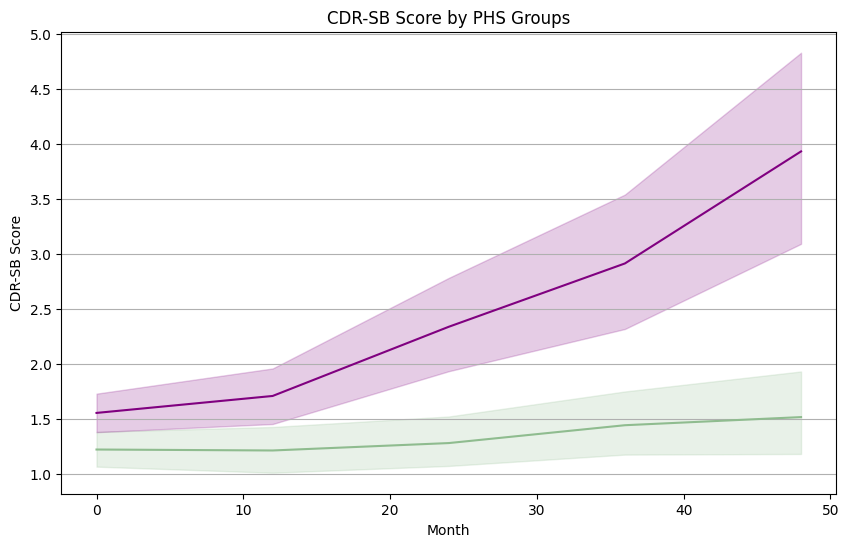

In [62]:
## PHS vs CDR-SB from baseline followed up to 48 month
# Filter the data based on PHS groups by the 0.210485 cutoff
df_negative = df[df['PHS'] <= 0.210485]
df_positive = df[df['PHS'] > 0.210485]

# Calculate the mean CDR-SB score and 95% CI for each combination of PHS group and VISCODE
df_negative_mean = df_negative.groupby(['PHS', 'VISCODE'])['CDRSB'].mean().reset_index()
df_negative_ci = df_negative.groupby(['PHS', 'VISCODE'])['CDRSB'].sem().mul(1.96).reset_index()
df_negative_mean['CDRSB_lower'] = df_negative_mean['CDRSB'] - df_negative_ci['CDRSB']
df_negative_mean['CDRSB_upper'] = df_negative_mean['CDRSB'] + df_negative_ci['CDRSB']

df_positive_mean = df_positive.groupby(['PHS', 'VISCODE'])['CDRSB'].mean().reset_index()
df_positive_ci = df_positive.groupby(['PHS', 'VISCODE'])['CDRSB'].sem().mul(1.96).reset_index()
df_positive_mean['CDRSB_lower'] = df_positive_mean['CDRSB'] - df_positive_ci['CDRSB']
df_positive_mean['CDRSB_upper'] = df_positive_mean['CDRSB'] + df_positive_ci['CDRSB']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the color palette
colors = ['darkseagreen', 'purple']

# Plot the CDR-SB scores with 95% CI for the PHS Negative group
sns.lineplot(data=df_negative_mean, x='VISCODE', y='CDRSB', color=colors[0], ax=ax)
ax.fill_between(df_negative_mean['VISCODE'], df_negative_mean['CDRSB_lower'], df_negative_mean['CDRSB_upper'], color=colors[0], alpha=0.3)

# Plot the CDR-SB scores with 95% CI for the PHS Positive group
sns.lineplot(data=df_positive_mean, x='VISCODE', y='CDRSB', color=colors[1], ax=ax)
ax.fill_between(df_positive_mean['VISCODE'], df_positive_mean['CDRSB_lower'], df_positive_mean['CDRSB_upper'], color=colors[1], alpha=0.3)

# Set the title and labels
ax.set_title('CDR-SB Score by PHS Groups')
ax.set_xlabel('Month')
ax.set_ylabel('CDR-SB Score')

# Remove the vertical grid lines
ax.grid(axis='y')

# Display the plot
plt.show()

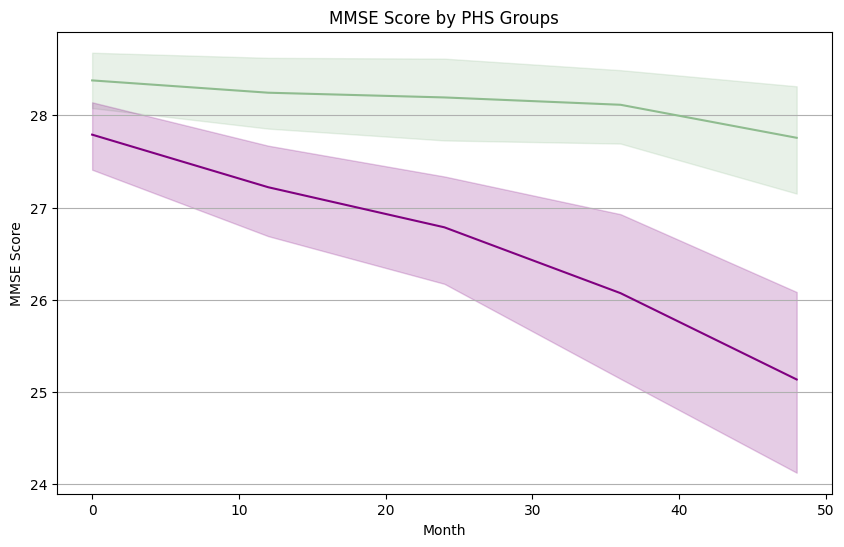

In [63]:
## PHS vs MMSE from baseline followed up to 48 month
# Filter the data based on PHS groups by the 0.210485cutoff
df_negative = df[df['PHS'] <= 0.210485]
df_positive = df[df['PHS'] > 0.210485]

# Calculate the mean MMSE score and 95% CI for each combination of PHS group and VISCODE
df_negative_mean = df_negative.groupby(['PHS', 'VISCODE'])['MMSE'].mean().reset_index()
df_negative_ci = df_negative.groupby(['PHS', 'VISCODE'])['MMSE'].sem().mul(1.96).reset_index()
df_negative_mean['MMSE_lower'] = df_negative_mean['MMSE'] - df_negative_ci['MMSE']
df_negative_mean['MMSE_upper'] = df_negative_mean['MMSE'] + df_negative_ci['MMSE']

df_positive_mean = df_positive.groupby(['PHS', 'VISCODE'])['MMSE'].mean().reset_index()
df_positive_ci = df_positive.groupby(['PHS', 'VISCODE'])['MMSE'].sem().mul(1.96).reset_index()
df_positive_mean['MMSE_lower'] = df_positive_mean['MMSE'] - df_positive_ci['MMSE']
df_positive_mean['MMSE_upper'] = df_positive_mean['MMSE'] + df_positive_ci['MMSE']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the color palette
colors = ['darkseagreen', 'purple']

# Plot the MMSE scores with 95% CI for the PHS Negative group
sns.lineplot(data=df_negative_mean, x='VISCODE', y='MMSE', color=colors[0], ax=ax)
ax.fill_between(df_negative_mean['VISCODE'], df_negative_mean['MMSE_lower'], df_negative_mean['MMSE_upper'], color=colors[0], alpha=0.3)

# Plot the MMSE scores with 95% CI for the PHS Positive group
sns.lineplot(data=df_positive_mean, x='VISCODE', y='MMSE', color=colors[1], ax=ax)
ax.fill_between(df_positive_mean['VISCODE'], df_positive_mean['MMSE_lower'], df_positive_mean['MMSE_upper'], color=colors[1], alpha=0.3)

# Set the title and labels
ax.set_title('MMSE Score by PHS Groups')
ax.set_xlabel('Month')
ax.set_ylabel('MMSE Score')

# Remove the vertical grid lines
ax.grid(axis='y')

# Display the plot
plt.show()

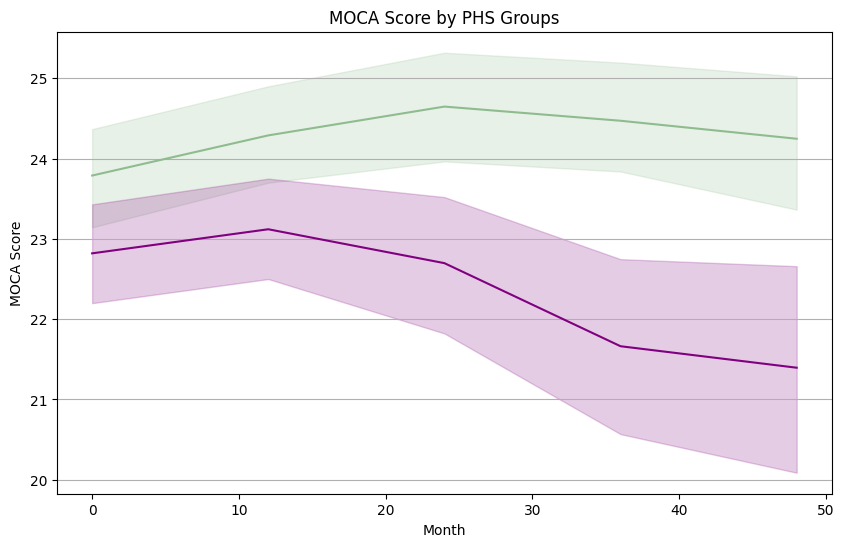

In [64]:
## PHS vs MOCA from baseline followed up to 48 month
# Filter the data based on PHS groups by the 0.210485 cutoff
df_negative = df[df['PHS'] <= 0.210485]
df_positive = df[df['PHS'] > 0.210485]

# Calculate the mean MOCA score and 95% CI for each combination of PHS group and VISCODE
df_negative_mean = df_negative.groupby(['PHS', 'VISCODE'])['MOCA'].mean().reset_index()
df_negative_ci = df_negative.groupby(['PHS', 'VISCODE'])['MOCA'].sem().mul(1.96).reset_index()
df_negative_mean['MOCA_lower'] = df_negative_mean['MOCA'] - df_negative_ci['MOCA']
df_negative_mean['MOCA_upper'] = df_negative_mean['MOCA'] + df_negative_ci['MOCA']

df_positive_mean = df_positive.groupby(['PHS', 'VISCODE'])['MOCA'].mean().reset_index()
df_positive_ci = df_positive.groupby(['PHS', 'VISCODE'])['MOCA'].sem().mul(1.96).reset_index()
df_positive_mean['MOCA_lower'] = df_positive_mean['MOCA'] - df_positive_ci['MOCA']
df_positive_mean['MOCA_upper'] = df_positive_mean['MOCA'] + df_positive_ci['MOCA']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the color palette
colors = ['darkseagreen', 'purple']

# Plot the MOCA scores with 95% CI for the PHS Negative group
sns.lineplot(data=df_negative_mean, x='VISCODE', y='MOCA', color=colors[0], ax=ax)
ax.fill_between(df_negative_mean['VISCODE'], df_negative_mean['MOCA_lower'], df_negative_mean['MOCA_upper'], color=colors[0], alpha=0.3)

# Plot the MOCA scores with 95% CI for the PHS Positive group
sns.lineplot(data=df_positive_mean, x='VISCODE', y='MOCA', color=colors[1], ax=ax)
ax.fill_between(df_positive_mean['VISCODE'], df_positive_mean['MOCA_lower'], df_positive_mean['MOCA_upper'], color=colors[1], alpha=0.3)

# Set the title and labels
ax.set_title('MOCA Score by PHS Groups')
ax.set_xlabel('Month')
ax.set_ylabel('MOCA Score')

# Remove the vertical grid lines
ax.grid(axis='y')

# Display the plot
plt.show()

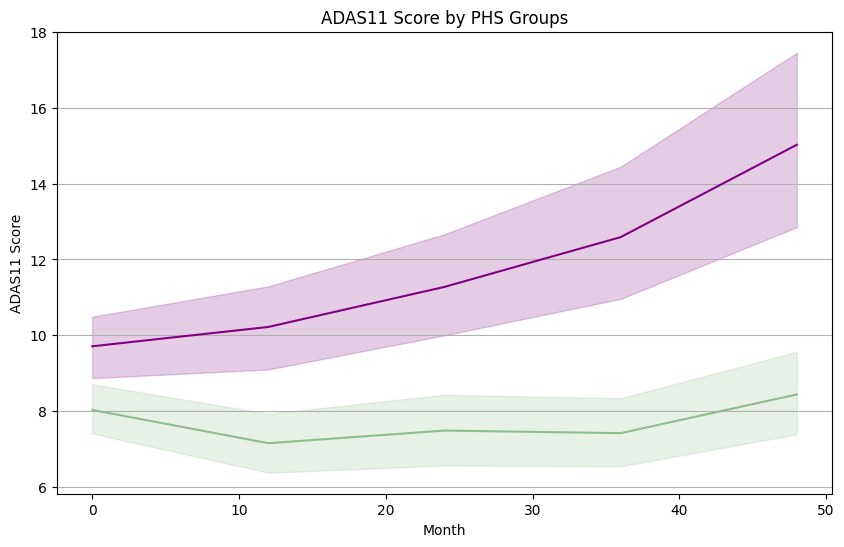

In [65]:
## PHS vs ADAS11 from baseline followed up to 48 month
# Filter the data based on PHS groups by the 0.210485 cutoff
df_negative = df[df['PHS'] <= 0.210485]
df_positive = df[df['PHS'] > 0.210485]

# Calculate the mean ADAS11 score and 95% CI for each combination of PHS group and VISCODE
df_negative_mean = df_negative.groupby(['PHS', 'VISCODE'])['ADAS11'].mean().reset_index()
df_negative_ci = df_negative.groupby(['PHS', 'VISCODE'])['ADAS11'].sem().mul(1.96).reset_index()
df_negative_mean['ADAS11_lower'] = df_negative_mean['ADAS11'] - df_negative_ci['ADAS11']
df_negative_mean['ADAS11_upper'] = df_negative_mean['ADAS11'] + df_negative_ci['ADAS11']

df_positive_mean = df_positive.groupby(['PHS', 'VISCODE'])['ADAS11'].mean().reset_index()
df_positive_ci = df_positive.groupby(['PHS', 'VISCODE'])['ADAS11'].sem().mul(1.96).reset_index()
df_positive_mean['ADAS11_lower'] = df_positive_mean['ADAS11'] - df_positive_ci['ADAS11']
df_positive_mean['ADAS11_upper'] = df_positive_mean['ADAS11'] + df_positive_ci['ADAS11']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the color palette
colors = ['darkseagreen', 'purple']

# Plot the ADAS11 scores with 95% CI for the PHS Negative group
sns.lineplot(data=df_negative_mean, x='VISCODE', y='ADAS11', color=colors[0], ax=ax)
ax.fill_between(df_negative_mean['VISCODE'], df_negative_mean['ADAS11_lower'], df_negative_mean['ADAS11_upper'], color=colors[0], alpha=0.3)

# Plot the ADAS11 scores with 95% CI for the PHS Positive group
sns.lineplot(data=df_positive_mean, x='VISCODE', y='ADAS11', color=colors[1], ax=ax)
ax.fill_between(df_positive_mean['VISCODE'], df_positive_mean['ADAS11_lower'], df_positive_mean['ADAS11_upper'], color=colors[1], alpha=0.3)

# Set the title and labels
ax.set_title('ADAS11 Score by PHS Groups')
ax.set_xlabel('Month')
ax.set_ylabel('ADAS11 Score')

# Remove the vertical grid lines
ax.grid(axis='y')

# Display the plot
plt.show()

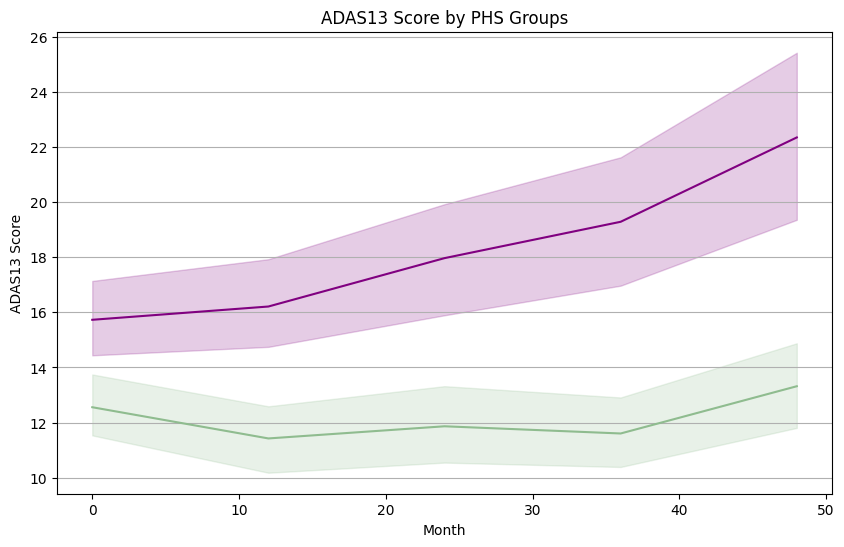

In [66]:
## PHS vs ADAS13 from baseline followed up to 48 month
# Filter the data based on PHS groups by the 0.210485 cutoff
df_negative = df[df['PHS'] <= 0.210485]
df_positive = df[df['PHS'] > 0.210485]

# Calculate the mean ADAS13 score and 95% CI for each combination of PHS group and VISCODE
df_negative_mean = df_negative.groupby(['PHS', 'VISCODE'])['ADAS13'].mean().reset_index()
df_negative_ci = df_negative.groupby(['PHS', 'VISCODE'])['ADAS13'].sem().mul(1.96).reset_index()
df_negative_mean['ADAS13_lower'] = df_negative_mean['ADAS13'] - df_negative_ci['ADAS13']
df_negative_mean['ADAS13_upper'] = df_negative_mean['ADAS13'] + df_negative_ci['ADAS13']

df_positive_mean = df_positive.groupby(['PHS', 'VISCODE'])['ADAS13'].mean().reset_index()
df_positive_ci = df_positive.groupby(['PHS', 'VISCODE'])['ADAS13'].sem().mul(1.96).reset_index()
df_positive_mean['ADAS13_lower'] = df_positive_mean['ADAS13'] - df_positive_ci['ADAS13']
df_positive_mean['ADAS13_upper'] = df_positive_mean['ADAS13'] + df_positive_ci['ADAS13']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the color palette
colors = ['darkseagreen', 'purple']

# Plot the ADAS13 scores with 95% CI for the PHS Negative group
sns.lineplot(data=df_negative_mean, x='VISCODE', y='ADAS13', color=colors[0], ax=ax)
ax.fill_between(df_negative_mean['VISCODE'], df_negative_mean['ADAS13_lower'], df_negative_mean['ADAS13_upper'], color=colors[0], alpha=0.3)

# Plot the ADAS13 scores with 95% CI for the PHS Positive group
sns.lineplot(data=df_positive_mean, x='VISCODE', y='ADAS13', color=colors[1], ax=ax)
ax.fill_between(df_positive_mean['VISCODE'], df_positive_mean['ADAS13_lower'], df_positive_mean['ADAS13_upper'], color=colors[1], alpha=0.3)

# Set the title and labels
ax.set_title('ADAS13 Score by PHS Groups')
ax.set_xlabel('Month')
ax.set_ylabel('ADAS13 Score')

# Remove the vertical grid lines
ax.grid(axis='y')

# Display the plot
plt.show()

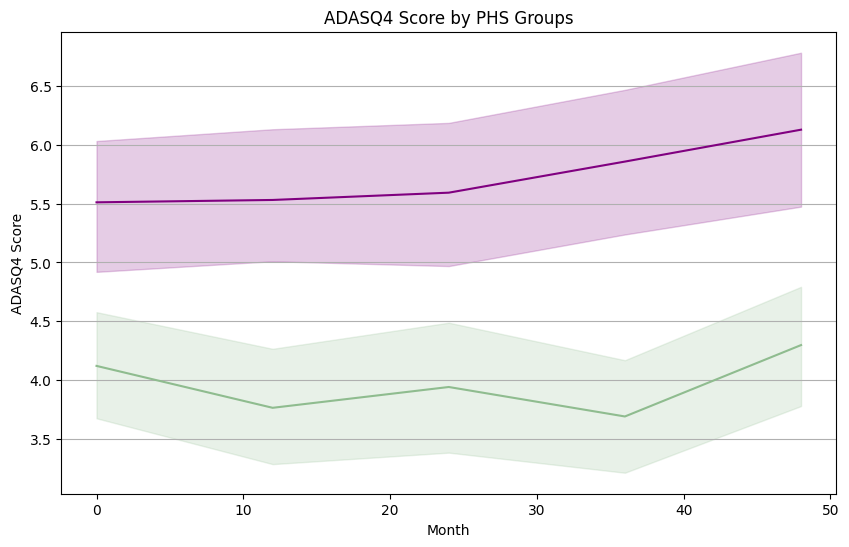

In [67]:
## PHS vs ADASQ4 from baseline followed up to 48 month
# Filter the data based on PHS groups by the 0.210485 cutoff
df_negative = df[df['PHS'] <= 0.210485]
df_positive = df[df['PHS'] > 0.210485]

# Calculate the mean ADASQ4 score and 95% CI for each combination of PHS group and VISCODE
df_negative_mean = df_negative.groupby(['PHS', 'VISCODE'])['ADASQ4'].mean().reset_index()
df_negative_ci = df_negative.groupby(['PHS', 'VISCODE'])['ADASQ4'].sem().mul(1.96).reset_index()
df_negative_mean['ADASQ4_lower'] = df_negative_mean['ADASQ4'] - df_negative_ci['ADASQ4']
df_negative_mean['ADASQ4_upper'] = df_negative_mean['ADASQ4'] + df_negative_ci['ADASQ4']

df_positive_mean = df_positive.groupby(['PHS', 'VISCODE'])['ADASQ4'].mean().reset_index()
df_positive_ci = df_positive.groupby(['PHS', 'VISCODE'])['ADASQ4'].sem().mul(1.96).reset_index()
df_positive_mean['ADASQ4_lower'] = df_positive_mean['ADASQ4'] - df_positive_ci['ADASQ4']
df_positive_mean['ADASQ4_upper'] = df_positive_mean['ADASQ4'] + df_positive_ci['ADASQ4']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the color palette
colors = ['darkseagreen', 'purple']

# Plot the ADASQ4 scores with 95% CI for the PHS Negative group
sns.lineplot(data=df_negative_mean, x='VISCODE', y='ADASQ4', color=colors[0], ax=ax)
ax.fill_between(df_negative_mean['VISCODE'], df_negative_mean['ADASQ4_lower'], df_negative_mean['ADASQ4_upper'], color=colors[0], alpha=0.3)

# Plot the ADASQ4 scores with 95% CI for the PHS Positive group
sns.lineplot(data=df_positive_mean, x='VISCODE', y='ADASQ4', color=colors[1], ax=ax)
ax.fill_between(df_positive_mean['VISCODE'], df_positive_mean['ADASQ4_lower'], df_positive_mean['ADASQ4_upper'], color=colors[1], alpha=0.3)

# Set the title and labels
ax.set_title('ADASQ4 Score by PHS Groups')
ax.set_xlabel('Month')
ax.set_ylabel('ADASQ4 Score')

# Remove the vertical grid lines
ax.grid(axis='y')

# Display the plot
plt.show()

Log-Rank Test: phs_bin=+ vs Others
Test statistic: 54.7852
P-value: 1.34e-13

Log-Rank Test: phs_bin=- vs Others
Test statistic: 54.7852
P-value: 1.34e-13



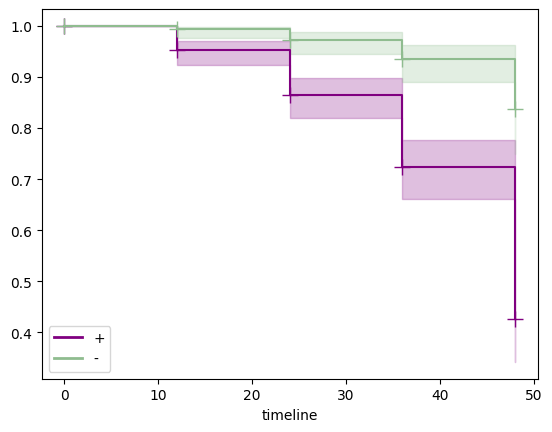

In [68]:

# Filter the data for MCI to AD transition
mci_to_ad_data = df[(df['DX'] == 'MCI') | (df['DX'] == 'AD')]

# Convert VISCODE column to numeric
mci_to_ad_data['VISCODE'] = pd.to_numeric(mci_to_ad_data['VISCODE'], errors='coerce')

# Drop rows with missing VISCODE values
mci_to_ad_data = mci_to_ad_data.dropna(subset=['VISCODE'])

# Assign numeric values to disease status
mci_to_ad_data['Disease'] = mci_to_ad_data['DX'].apply(lambda x: 1 if x == 'AD' else 0)

# Create Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Create a plot with custom colors for each phs_bin group
fig, ax = plt.subplots()

# Fit the survival curves based on the phs_bin groups
for phs_bin, group_data in mci_to_ad_data.groupby('phs_bin'):
    kmf.fit(group_data['VISCODE'], event_observed=group_data['Disease'], label=f'phs_bin={phs_bin}')
    kmf.plot(ci_show=True, show_censors=True, ax=ax, linestyle='-', color='purple' if phs_bin == '+' else 'darkseagreen')

    # Perform log-rank test for each phs_bin group against all others
    other_groups = mci_to_ad_data[mci_to_ad_data['phs_bin'] != phs_bin]
    results = logrank_test(group_data['VISCODE'], other_groups['VISCODE'], group_data['Disease'], other_groups['Disease'], alpha=0.95)
    print(f"Log-Rank Test: phs_bin={phs_bin} vs Others")
    print(f"Test statistic: {results.test_statistic:.4f}")
    print(f"P-value: {results.p_value:.2e}")
    print()

# Set custom colors for positive and negative groups in the legend
legend_colors = [plt.Line2D([0], [0], linestyle='-', color='purple', lw=2),
                 plt.Line2D([0], [0], linestyle='-', color='darkseagreen', lw=2)]

# Add legend to the plot
ax.legend(legend_colors, ['+', '-'])

# Show the plot
plt.show()


In [74]:
# Binarize the phs_bin column
label_encoder = LabelEncoder()
mci_to_ad_data['phs_bin'] = label_encoder.fit_transform(mci_to_ad_data['phs_bin'])
cph = CoxPHFitter()

# Select the columns for analysis
columns = ['phs_bin', 'VISCODE', 'Disease']

# Subset the dataset with the selected columns
mci_to_ad_data = mci_to_ad_data[columns]

# Fit the Cox proportional hazards model
cph.fit(mci_to_ad_data, duration_col='VISCODE', event_col='Disease')

# Calculate the hazard ratio
hazard_ratio = np.exp(-cph.params_[0])

# Print the hazard ratio and confidence interval
print("Hazard Ratio: {:.4f}".format(hazard_ratio))

Hazard Ratio: 4.9439
